Kristen Swerzenski

DSC 680 Applied Data Science

Term Project 1

# Project 1: Analyzing Trends in Extreme Weather Events

In [1]:
import pandas as pd
import glob

In [2]:
pd.set_option('display.max_columns', None)

## Reading in the data:

Since each data file from the NOAA Storm Events Database is in a separate .csv file by year, I'm using th glob module to read them all at once since they all follow a similar pattern. Each data frame will be saved into a list of all the data frames by year, and I do a quick check to make sure that each data set has the same structure (even though I visually checked each one prior and am almost certain each year is identical, it never hurts to double check). once those checks are complete, I concatenate all of the years of my data together to make a complete dataset of major weather events from the years 2014-2024 in the US. 

In [3]:
# Defining the file name pattern and using glob to bring in all files following the pattern
file_pattern = "StormEvents_details-ftp_v1.0_d*.csv"
files = glob.glob(file_pattern)

In [4]:
# Reading all files into data frames and storing in a list
dataframes = [pd.read_csv(file) for file in files]

C:\Users\krist\AppData\Local\Temp\ipykernel_6768\2950044572.py:2: DtypeWarning: Columns (29,34,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes = [pd.read_csv(file) for file in files]


In [5]:
# Extracting the columns from each data frame
column_sets = [set(df.columns) for df in dataframes]

In [6]:
# Checking all column names of each data frame against each other for consistency
all_columns_identical = all(cols == column_sets[0] for cols in column_sets)
if all_columns_identical:
    print("All good! All files have the same structure.")
else:
    print("Something's not right!")
    for idx, cols in enumerate(column_sets):
        print(f"File {files[idx]} has columns: {cols}")

All good! All files have the same structure.


In [7]:
# If the columns all match, concatenating them into a single data frame and printing an error if concat fails
if all_columns_identical:
    # Concatenate all DataFrames
    combined_data = pd.concat(dataframes, ignore_index=True)
    print("All files have been successfully concatenated into a single DataFrame.")
else:
    print("Cannot concatenate files due to structural differences.")

All files have been successfully concatenated into a single DataFrame.


In [8]:
# Checking combined data frame
combined_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,200412,29,1800,200412,30,1200,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
1,200412,29,1800,200412,30,1200,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85K,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
2,200412,8,1800,200412,8,1800,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,NaN,NaN,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS
3,200412,19,1500,200412,19,1700,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS
4,200412,14,600,200412,14,800,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,NaN,NaN,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS


In [9]:
# Checking combined data frame shape
combined_data.shape

(1304363, 51)

## Data Cleaning and Preparation

This data has quite a few formatting issues that will need to be addressed before being able to use it for modeling. First, the begin_year and end_year columns did not import correctly and mased together with the begin and end years, so I'll have to split those out manually. I also want to rearraange the columns when I do to keep the event date information all together (and for my oen sanity when I inevitably go looking for them later and they are not where I think they should be).

In [10]:
# Splitting out the month and year that the weather event began
combined_data['BEGIN_YEAR'] = combined_data['BEGIN_YEARMONTH'] // 100
combined_data['BEGIN_MONTH'] = combined_data['BEGIN_YEARMONTH'] % 100
combined_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,BEGIN_YEAR,BEGIN_MONTH
0,200412,29,1800,200412,30,1200,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS,2004,12
1,200412,29,1800,200412,30,1200,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85K,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS,2004,12
2,200412,8,1800,200412,8,1800,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,NaN,NaN,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS,2004,12
3,200412,19,1500,200412,19,1700,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS,2004,12
4,200412,14,600,200412,14,800,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,NaN,NaN,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS,2004,12


In [11]:
# Splitting out the month and year that the weather event ended
combined_data['END_YEAR'] = combined_data['END_YEARMONTH'] // 100  # Integer division to extract the year
combined_data['END_MONTH'] = combined_data['END_YEARMONTH'] % 100
combined_data.head()

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,BEGIN_YEAR,BEGIN_MONTH,END_YEAR,END_MONTH
0,200412,29,1800,200412,30,1200,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS,2004,12,2004,12
1,200412,29,1800,200412,30,1200,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85K,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS,2004,12,2004,12
2,200412,8,1800,200412,8,1800,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,NaN,NaN,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS,2004,12,2004,12
3,200412,19,1500,200412,19,1700,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS,2004,12,2004,12
4,200412,14,600,200412,14,800,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,NaN,NaN,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS,2004,12,2004,12


In [12]:
# Reordering columns for my sanity
columns = combined_data.columns.tolist()

# Removing BEGIN_YEAR, BEGIN_MONTH, END_YEAR, and END_MONTH temporarily
columns.remove('BEGIN_YEAR')
columns.remove('BEGIN_MONTH')
columns.remove('END_YEAR')
columns.remove('END_MONTH')

# Moving BEGIN_YEAR and BEGIN_MONTH to the beginning
new_order = ['BEGIN_YEAR', 'BEGIN_MONTH']

# Finding the index of BEGIN_TIME and inserting END_YEAR and END_MONTH after it
begin_time_index = columns.index('BEGIN_TIME') + 1
new_order += columns[:begin_time_index] + ['END_YEAR', 'END_MONTH'] + columns[begin_time_index:]

# Reordering the data frame to match previously defined new order
combined_data = combined_data[new_order]

# Checking to make sure everything is where I want it
combined_data.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,2004,12,200412,29,1800,2004,12,200412,30,1200,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
1,2004,12,200412,29,1800,2004,12,200412,30,1200,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85K,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
2,2004,12,200412,8,1800,2004,12,200412,8,1800,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,NaN,NaN,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS
3,2004,12,200412,19,1500,2004,12,200412,19,1700,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS
4,2004,12,200412,14,600,2004,12,200412,14,800,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,NaN,NaN,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS


In [13]:
# Dropping the messy columns
combined_data = combined_data.drop(['BEGIN_YEARMONTH','END_YEARMONTH'], axis=1)
combined_data.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,2004,12,29,1800,2004,12,30,1200,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
1,2004,12,29,1800,2004,12,30,1200,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85K,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
2,2004,12,8,1800,2004,12,8,1800,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,NaN,NaN,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS
3,2004,12,19,1500,2004,12,19,1700,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS
4,2004,12,14,600,2004,12,14,800,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,NaN,NaN,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS


Next, the time columns all came in as integers and I want them in datetime just in case I find use for them in my analysis. 

In [14]:
# Defining the columns that contain times
time_columns = ['BEGIN_TIME', 'END_TIME']

In [15]:
# Iterating through time columns and converting them to datetime
for col in time_columns:
    combined_data[col] = combined_data[col].astype(str).str.zfill(4)
    combined_data[col] = pd.to_datetime(combined_data[col], format='%H%M').dt.time

# Checking the conversion
combined_data.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,2004,12,29,18:00:00,2004,12,30,12:00:00,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
1,2004,12,29,18:00:00,2004,12,30,12:00:00,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85K,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
2,2004,12,8,18:00:00,2004,12,8,18:00:00,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,NaN,NaN,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS
3,2004,12,19,15:00:00,2004,12,19,17:00:00,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS
4,2004,12,14,06:00:00,2004,12,14,08:00:00,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,NaN,NaN,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS


The next thing that I need to handle is how the data for damage to property and crops is formatted. The values in these columns represent currency, but they are currently formatted with values like 87K or 1.2M. To handle this and convert these values from strings to actual usable numbers, I am going to write a function that will remove the letters from the values and convert the values to the appropriate numeric value based on the suffix (thousands for 'k' and millions forn 'm'). I also include some additional handling of NaN values since some of the events do not have damage costs associated with them, and I want to ensure that the presence of NaN values does not impact the conversion of actual values. I also create a new variable that combines the values for damage to crops and the damage to property into a single variable for total damage costs.

In [16]:
# Defining a function to handle the conversion from suffix-based values
def convert_to_numeric(value):
    if pd.isna(value):  # Handling NaN values
        return value
    value = str(value).strip() 
    multiplier = 1

    # Assigning appropriate nultiplier based on suffix and removing non-numeric characters
    if value.endswith('K') or value.endswith('k'):
        multiplier = 1_000
        value = value[:-1] 
    elif value.endswith('M') or value.endswith('m'):
        multiplier = 1_000_000
        value = value[:-1]
    # Converting numeric values to floats and applying appropriate multipler
    try:
        return float(value) * multiplier  
    except ValueError:
        return value  # If conversion fails, return the original value

In [17]:
# Applying the function
combined_data['DAMAGE_PROPERTY'] = combined_data['DAMAGE_PROPERTY'].apply(convert_to_numeric)
combined_data['DAMAGE_CROPS'] = combined_data['DAMAGE_CROPS'].apply(convert_to_numeric)

# Checking conversions
combined_data.head(10)

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
0,2004,12,29,18:00:00,2004,12,30,12:00:00,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
1,2004,12,29,18:00:00,2004,12,30,12:00:00,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85000.0,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS
2,2004,12,8,18:00:00,2004,12,8,18:00:00,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,NaN,NaN,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS
3,2004,12,19,15:00:00,2004,12,19,17:00:00,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS
4,2004,12,14,06:00:00,2004,12,14,08:00:00,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,NaN,NaN,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS
5,2004,12,21,04:00:00,2004,12,21,08:00:00,1183013,5430322,MICHIGAN,26,2004,December,Winter Storm,Z,19,CHARLEVOIX,APX,21-DEC-04 04:00:00,EST,21-DEC-04 08:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A strong low pressure system slowed as it move...,NaN,PDS
6,2004,12,21,04:00:00,2004,12,21,08:00:00,1183013,5430323,MICHIGAN,26,2004,December,Winter Storm,Z,16,EMMET,APX,21-DEC-04 04:00:00,EST,21-DEC-04 08:00:00,0,0,0,0,NaN,NaN,LAW ENFORCEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A strong low pressure system slowed as it move...,NaN,PDS
7,2004,12,26,15:00:00,2004,12,27,08:00:00,1182925,5430420,MASSACHUSETTS,25,2004,December,Winter Storm,Z,20,SOUTHERN BRISTOL,BOX,26-DEC-04 15:00:00,EST,27-DEC-04 08:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A powerful winter storm brought heavy snow and...,NaN,PDS
8,2004,12,26,15:00:00,2004,12,27,08:00:00,1182925,5430421,MASSACHUSETTS,25,2004,December,Winter Storm,Z,21,SOUTHERN PLYMOUTH,BOX,26-DEC-04 15:00:00,EST,27-DEC-04 08:00:00,0,0,0,0,NaN,NaN,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A powerful winter storm brought heavy snow and...,NaN,PDS
9,2004,12,11,08:00:00,2004,12,11,13:00:00,1182849,5430278,DELAWARE,10,2004,December,Storm Surge/Tide,Z,2,KENT,PHI,11-DEC-04 08:00:00,EST,11-DEC-04 13:00:00,0,0,0,0,NaN,0.0,COASTAL OBSERVING STATION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The com

In [18]:
# Ensuring damage values are now numeric data types
combined_data['DAMAGE_PROPERTY'] = pd.to_numeric(combined_data['DAMAGE_PROPERTY'], errors='coerce')
combined_data['DAMAGE_CROPS'] = pd.to_numeric(combined_data['DAMAGE_CROPS'], errors='coerce')

In [19]:
# Filling NaN values with 0, indicating no damages attributed to the event
combined_data['DAMAGE_PROPERTY'] = combined_data['DAMAGE_PROPERTY'].fillna(0)
combined_data['DAMAGE_CROPS'] = combined_data['DAMAGE_CROPS'].fillna(0)

# Creating a total_damages variable with combined property and crop damage values
combined_data['TOTAL_DAMAGE'] = combined_data['DAMAGE_PROPERTY'] + combined_data['DAMAGE_CROPS']

I want to do a similar thing that I just did for total damages for injuries and fatalities as well, so I am going to create two additional variables for total_injuries and total_deaths that are combinations of indirect and direct deaths/injuries attributed to the weather event.

In [20]:
# Creating two new variables for total direct + indirect deaths and injuries
combined_data['TOTAL_FATALITIES'] = combined_data['DEATHS_DIRECT'] + combined_data['DEATHS_INDIRECT']
combined_data['TOTAL_INJURIES'] = combined_data['INJURIES_DIRECT'] + combined_data['INJURIES_INDIRECT']

Last, I am going to do a little reformatting of the dates to make running the SARIMAs a little easier.

In [21]:
# Reformatting dates for visualizations and SARIMA
combined_data['MONTH'] = pd.to_datetime(combined_data['MONTH_NAME'], format='%B', errors='coerce').dt.month

combined_data['DATE'] = pd.to_datetime(combined_data[['YEAR', 'MONTH']].assign(DAY=1))  

In [22]:
# Checking cleaned data frame
combined_data.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TOTAL_DAMAGE,TOTAL_FATALITIES,TOTAL_INJURIES,MONTH,DATE
0,2004,12,29,18:00:00,2004,12,30,12:00:00,1182771,5430389,MONTANA,30,2004,December,Heavy Snow,Z,6,BITTERROOT / SAPPHIRE MOUNTAINS,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,0.0,0.0,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS,0.0,0,0,12,2004-12-01
1,2004,12,29,18:00:00,2004,12,30,12:00:00,1182771,5430390,MONTANA,30,2004,December,Heavy Snow,Z,7,BUTTE / PINTLAR REGION,MSO,29-DEC-04 18:00:00,MST,30-DEC-04 12:00:00,0,0,0,0,85000.0,0.0,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Heavy snow event across southwest Montana brou...,NaN,PDS,85000.0,0,0,12,2004-12-01
2,2004,12,8,18:00:00,2004,12,8,18:00:00,1182769,5430387,IDAHO,16,2004,December,Winter Storm,Z,5,NORTHERN CLEARWATER MOUNTAINS,MSO,08-DEC-04 18:00:00,MST,08-DEC-04 18:00:00,0,0,0,0,0.0,0.0,OTHER FEDERAL AGENCY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A vigorous winter storm brought strong winds a...,NaN,PDS,0.0,0,0,12,2004-12-01
3,2004,12,19,15:00:00,2004,12,19,17:00:00,1182770,5430388,MONTANA,30,2004,December,High Wind,Z,5,MISSOULA / BITTERROOT VALLEYS,MSO,19-DEC-04 15:00:00,MST,19-DEC-04 17:00:00,0,0,0,0,0.0,0.0,LAW ENFORCEMENT,56.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prefrontal winds were channeled through east t...,NaN,PDS,0.0,0,0,12,2004-12-01
4,2004,12,14,06:00:00,2004,12,14,08:00:00,1182772,5430391,MONTANA,30,2004,December,Winter Weather,Z,1,KOOTENAI/CABINET REGION,MSO,14-DEC-04 06:00:00,MST,14-DEC-04 08:00:00,0,0,0,0,0.0,0.0,DEPT OF HIGHWAYS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A winter storm with light snow followed by fre...,NaN,PDS,0.0,0,0,12,2004-12-01


## Exploratory Data Analysis

Now that the data is cleaned, I am going to perform a little exploratory analysis of the data to see where I might want to focus my attention. I am going to start just by gathering some information about types of weather events included in the data, as well as pulling some summary stats on events that had the highest damage and human life impacts.

In [23]:
# Getting a list of the unique weather events included in this data set
unique_event_types = combined_data['EVENT_TYPE'].unique()
unique_event_types_list = unique_event_types.tolist()
for event in unique_event_types_list:
    print(event)

Heavy Snow
Winter Storm
High Wind
Winter Weather
Storm Surge/Tide
Thunderstorm Wind
Ice Storm
Tornado
Lightning
Heavy Rain
Flash Flood
Hail
Strong Wind
High Surf
Flood
Tropical Storm
Blizzard
Hurricane (Typhoon)
Frost/Freeze
Dense Fog
Cold/Wind Chill
Marine Thunderstorm Wind
Waterspout
Avalanche
Funnel Cloud
Debris Flow
Wildfire
Dust Storm
Rip Current
Sleet
Heat
Drought
Volcanic Ash
Seiche
Dust Devil
Marine Hail
Freezing Fog
Coastal Flood
Lake-Effect Snow
Marine High Wind
Dense Smoke
Tsunami
Extreme Cold/Wind Chill
Marine Strong Wind
Lakeshore Flood
Excessive Heat
Astronomical Low Tide
Tropical Depression
Volcanic Ashfall
Sneakerwave
Marine Tropical Storm
Marine Dense Fog
Marine Hurricane/Typhoon
Marine Lightning
Marine Tropical Depression
Hurricane


In [24]:
# Pulling summaries of the event types with the higest damages each year
damage_by_event_type = combined_data.groupby(['BEGIN_YEAR', 'EVENT_TYPE'])['TOTAL_DAMAGE'].sum().reset_index()

# Sorting the results by total damage in descending order for each year
damage_by_event_type_sorted = damage_by_event_type.sort_values(by=['BEGIN_YEAR', 'TOTAL_DAMAGE'], ascending=[True, False])

# Showing the top event types by total damage for each year
damage_by_event_type_sorted

,BEGIN_YEAR,EVENT_TYPE,TOTAL_DAMAGE
17,2004,High Wind,3.517826e+09
18,2004,Hurricane (Typhoon),2.924826e+09
9,2004,Flood,1.173642e+09
8,2004,Flash Flood,8.688842e+08
30,2004,Tropical Storm,6.014250e+08
...,...,...,...
981,2024,Seiche,0.000000e+00
982,2024,Sleet,0.000000e+00
983,2024,Sneakerwave,0.000000e+00
988,2024,Tropical Depression,0.000000e+00


In [25]:
# refining to show the top 5 costliest weather events by year 
top_5_per_year = damage_by_event_type.groupby('BEGIN_YEAR').apply(lambda x: x.nlargest(5, 'TOTAL_DAMAGE')).reset_index(drop=True)

# Display the result
top_5_per_year

,BEGIN_YEAR,EVENT_TYPE,TOTAL_DAMAGE
0,2004,High Wind,3.517826e+09
1,2004,Hurricane (Typhoon),2.924826e+09
2,2004,Flood,1.173642e+09
3,2004,Flash Flood,8.688842e+08
4,2004,Tropical Storm,6.014250e+08
...,...,...,...
100,2024,Tornado,9.550430e+08
101,2024,Wildfire,4.968800e+08
102,2024,Hail,3.688344e+08
103,2024,Thunderstorm Wind,3.627818e+08


In [26]:
# Gathering a summary of the top events by overall fatalities, damage, and injuries
summary = combined_data.groupby('EVENT_TYPE').agg(
    TOTAL_FATALITIES=('TOTAL_FATALITIES', 'sum'),
    TOTAL_DAMAGE=('TOTAL_DAMAGE', 'sum'),
    TOTAL_INJURIES=('TOTAL_INJURIES', 'sum')
).reset_index()

In [27]:
# Sorting each list by descending order
top_fatalities = summary.sort_values(by='TOTAL_FATALITIES', ascending=False)[['EVENT_TYPE', 'TOTAL_FATALITIES']]
top_damages = summary.sort_values(by='TOTAL_DAMAGE', ascending=False)[['EVENT_TYPE', 'TOTAL_DAMAGE']]
top_injuries = summary.sort_values(by='TOTAL_INJURIES', ascending=False)[['EVENT_TYPE', 'TOTAL_INJURIES']]

In [28]:
# Showing events with the highest fatalities
top_fatalities.head(10)

,EVENT_TYPE,TOTAL_FATALITIES
19,Heat,2341
11,Excessive Heat,2062
46,Tornado,1660
13,Flash Flood,1372
39,Rip Current,1105
25,Hurricane (Typhoon),1075
55,Winter Weather,988
45,Thunderstorm Wind,694
29,Lightning,605
14,Flood,583


In [29]:
# Showing events with the highest total damage costs
top_damages.head(10)

,EVENT_TYPE,TOTAL_DAMAGE
13,Flash Flood,4.474690e+10
24,Hurricane,3.021541e+10
14,Flood,2.837313e+10
46,Tornado,2.263610e+10
18,Hail,2.206984e+10
25,Hurricane (Typhoon),2.053744e+10
8,Drought,1.750279e+10
23,High Wind,1.096917e+10
43,Storm Surge/Tide,9.744764e+09
48,Tropical Storm,9.569291e+09


In [30]:
# Showing events with the highest injury rates
top_injuries.head(10)

,EVENT_TYPE,TOTAL_INJURIES
46,Tornado,19250
11,Excessive Heat,7789
19,Heat,6792
55,Winter Weather,5890
45,Thunderstorm Wind,4630
25,Hurricane (Typhoon),3434
29,Lightning,3333
54,Winter Storm,2179
53,Wildfire,1985
26,Ice Storm,1576


## Visualizations

To continue my exploratory analysis, I am going to make some visualizations to better illustrate where areas of interest might be, focusing mainly on seeing which types of extreme weather events happen most frequently, have the highest damage costs associated with them, and have the highest threats to human life.

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Looking at trends in property and crop damage over time

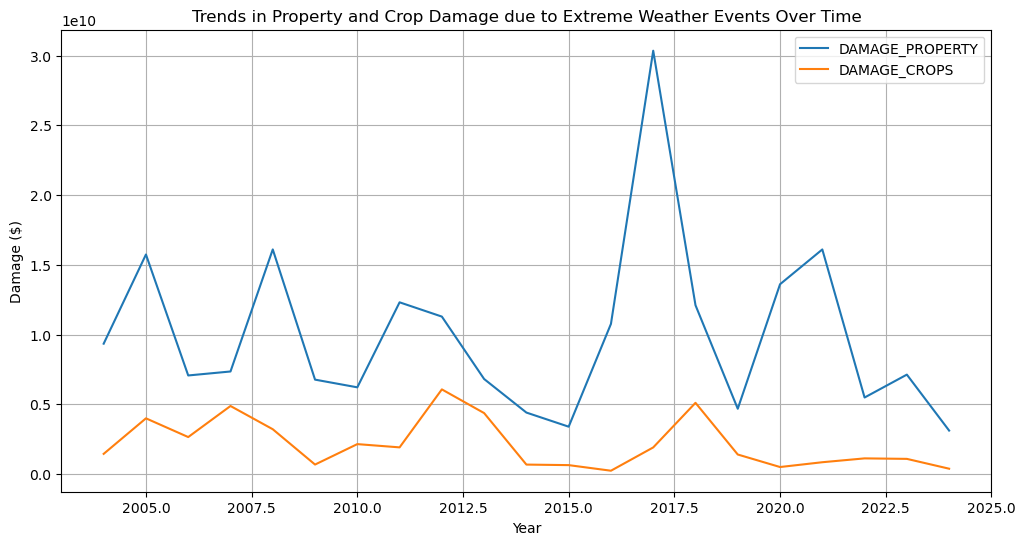

In [32]:
# Grouping by BEGIN_YEAR and summing the crop and proprty damage
time_data = combined_data.groupby('BEGIN_YEAR')[['DAMAGE_PROPERTY', 'DAMAGE_CROPS']].sum()

# Plotting property and crop damages over time
import matplotlib.pyplot as plt
time_data.plot(kind='line', figsize=(12, 6))
plt.title("Trends in Property and Crop Damage due to Extreme Weather Events Over Time")
plt.xlabel("Year")
plt.ylabel("Damage ($)")
plt.grid()
plt.show()

#### Most frequent extreme weather events

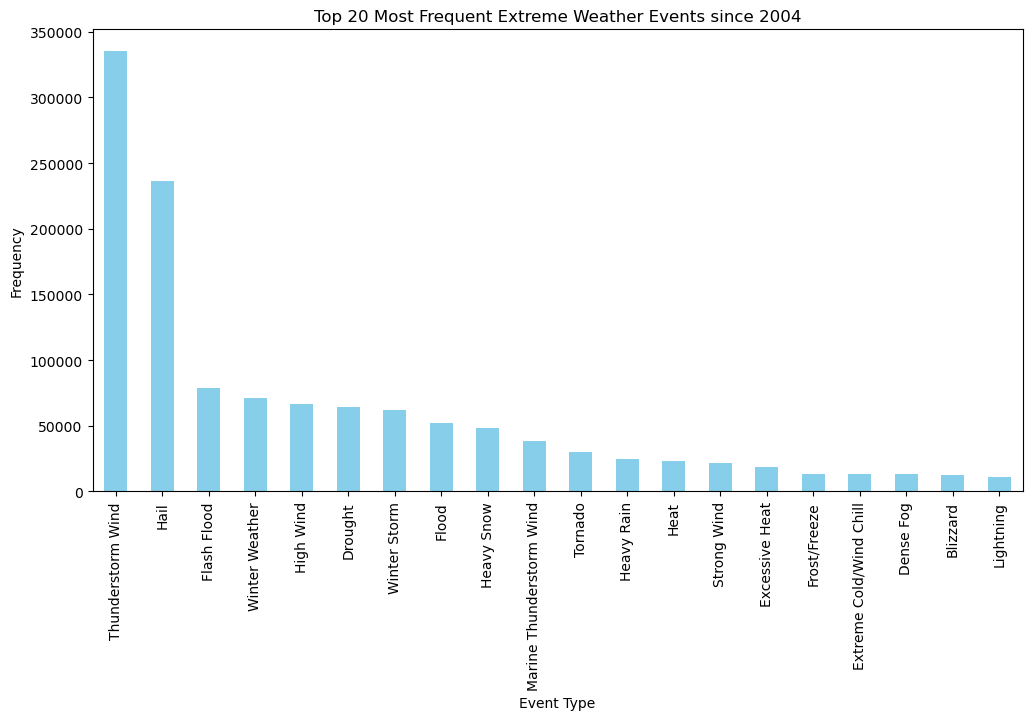

In [33]:
# Counting occurrences by event type
event_counts = combined_data['EVENT_TYPE'].value_counts().head(20)

# Making a bar plot
event_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title("Top 20 Most Frequent Extreme Weather Events since 2004")
plt.xlabel("Event Type")
plt.ylabel("Frequency")
plt.show()

#### Trends of the top 10 most documented extreme weather events over time

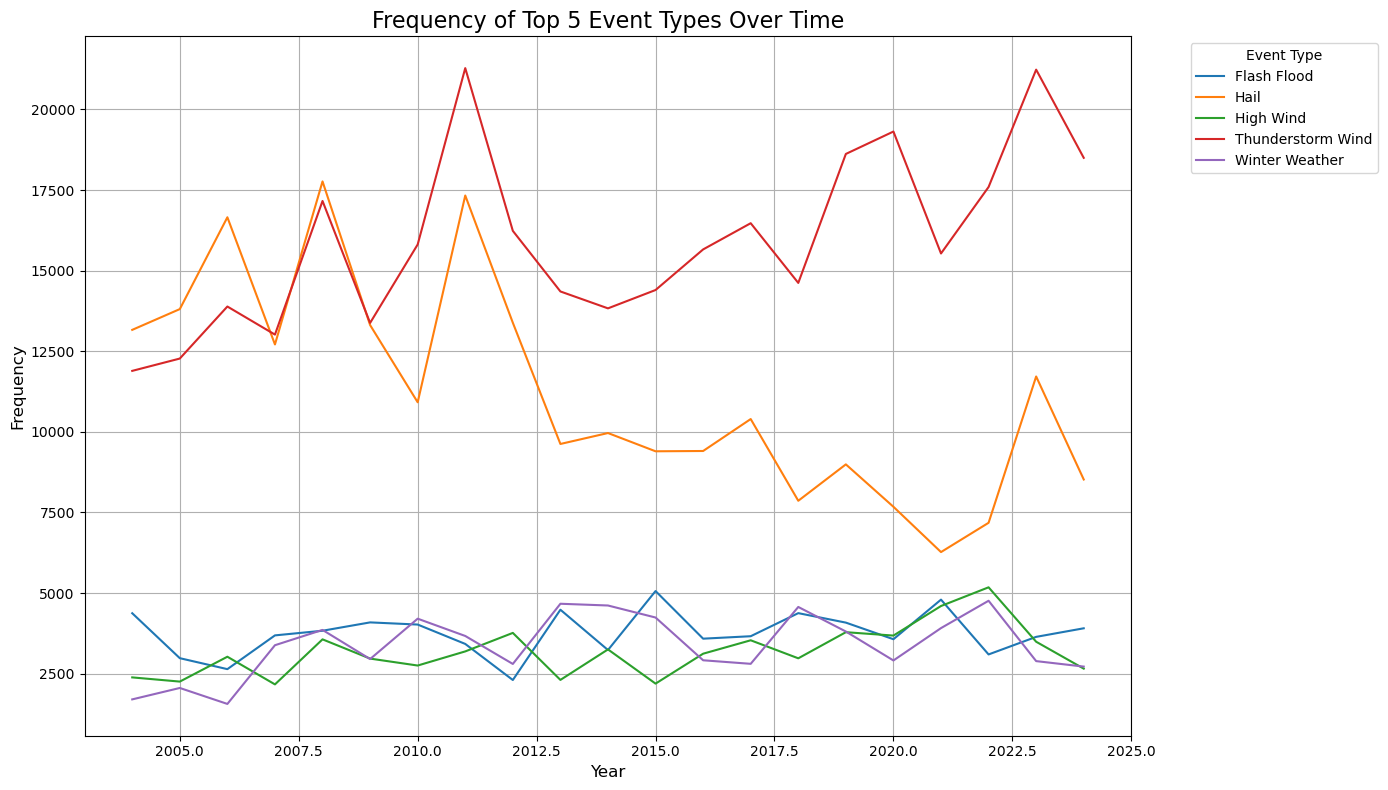

In [34]:
# Counting the total occurrences of each event type
total_event_counts = combined_data['EVENT_TYPE'].value_counts()

# Getting the top 5 most frequent event types
top_5_event_types = total_event_counts.head(5).index

# Filtering the data for only the top 5 event types
filtered_data = combined_data[combined_data['EVENT_TYPE'].isin(top_5_event_types)]

# Counting occurrences of the top 5 event types by year
event_type_counts = filtered_data.groupby(['BEGIN_YEAR', 'EVENT_TYPE']).size().unstack(fill_value=0)

# Plotting the data
plt.figure(figsize=(14, 8))
for event_type in event_type_counts.columns:
    plt.plot(event_type_counts.index, event_type_counts[event_type], label=event_type)

plt.title("Frequency of Top 5 Event Types Over Time", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend(title="Event Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

#### Top 10 weather events by fatalities, injuries, and total damage costs

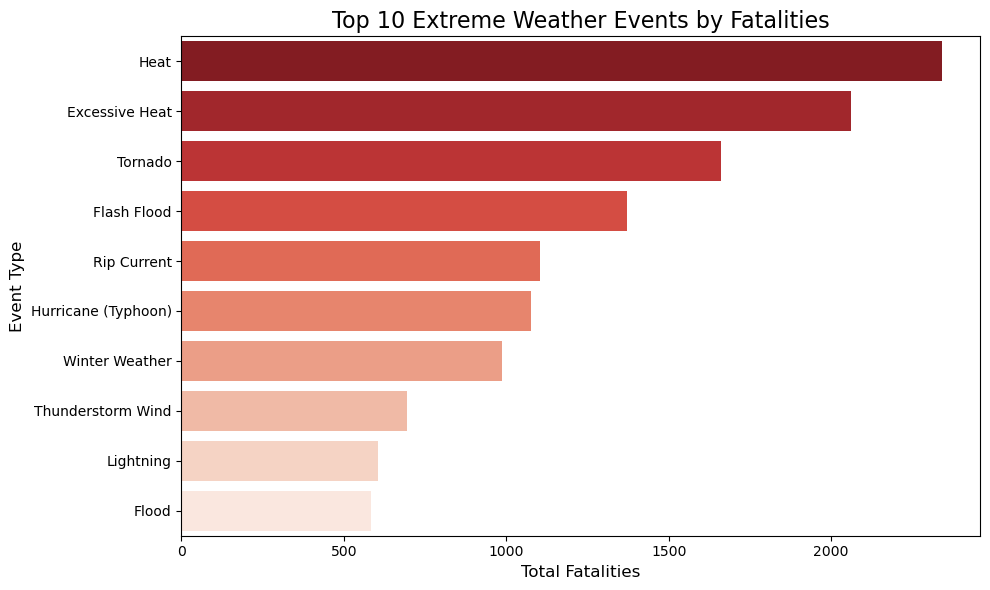

In [35]:
# Plotting top 10 extreme weather events by number of fatalities
plt.figure(figsize=(10, 6))
sns.barplot(
    y='EVENT_TYPE', 
    x='TOTAL_FATALITIES', 
    data=top_fatalities.head(10), 
    palette="Reds_r"
)
plt.title('Top 10 Extreme Weather Events by Fatalities', fontsize=16)
plt.xlabel('Total Fatalities', fontsize=12)
plt.ylabel('Event Type', fontsize=12)
plt.tight_layout()
plt.show()

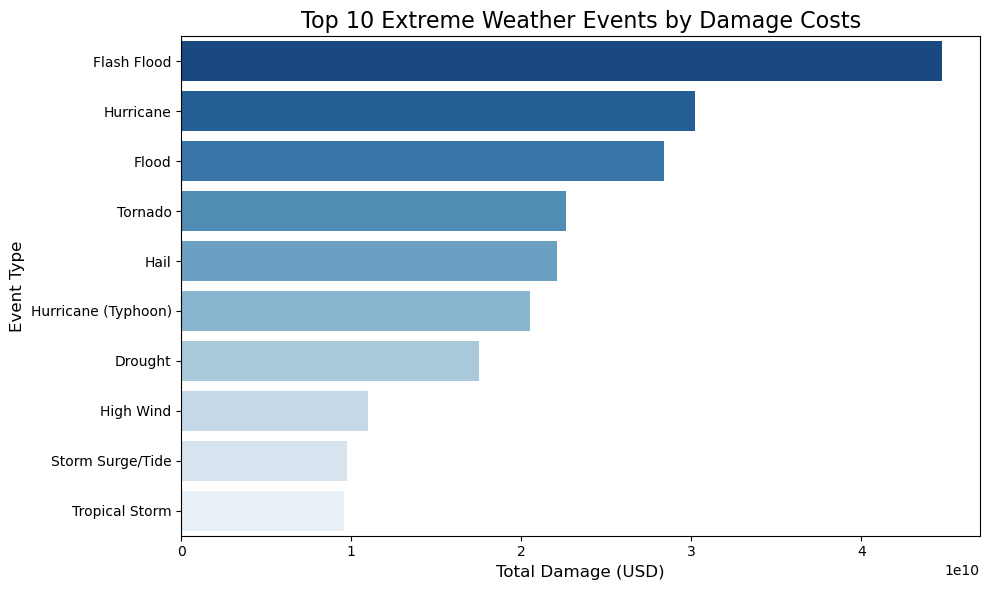

In [36]:
# Plotting top 10 extreme weather events by damage costs
plt.figure(figsize=(10, 6))
sns.barplot(
    y='EVENT_TYPE', 
    x='TOTAL_DAMAGE', 
    data=top_damages.head(10),  # Show top 10 events
    palette="Blues_r"
)
plt.title('Top 10 Extreme Weather Events by Damage Costs', fontsize=16)
plt.xlabel('Total Damage (USD)', fontsize=12)
plt.ylabel('Event Type', fontsize=12)
plt.tight_layout()
plt.show()

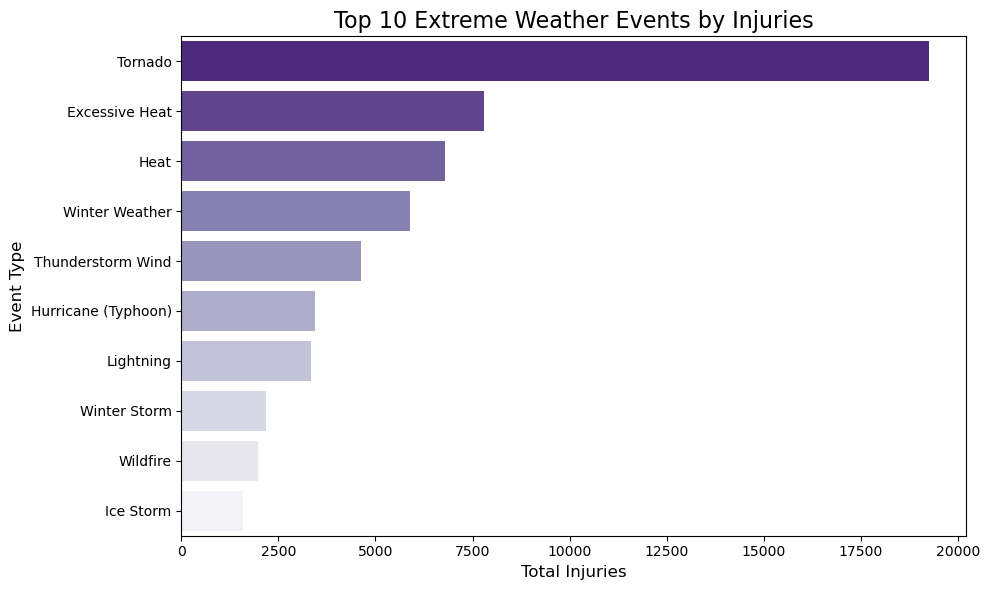

In [37]:
# Plotting top 10 extreme weather events by number of injuries
plt.figure(figsize=(10, 6))
sns.barplot(
    y='EVENT_TYPE', 
    x='TOTAL_INJURIES', 
    data=top_injuries.head(10),  # Show top 10 events
    palette="Purples_r"
)
plt.title('Top 10 Extreme Weather Events by Injuries', fontsize=16)
plt.xlabel('Total Injuries', fontsize=12)
plt.ylabel('Event Type', fontsize=12)
plt.tight_layout()
plt.show()

## SARIMA Modeling

To analyze and forecast extreme weather events, I chose to use Seasonal Autoregressive Integrated Moving Average (SARIMA) models. This method was chosen due to its ability to handle both trend and seasonality, which are inherent characteristics of extreme weather event data. SARIMA is well-suited for identifying trends, seasonal patterns, and other time-dependent behaviors in the data, making it ideal for analyzing extreme weather events, which often follow seasonal and cyclical patterns. I am going to run a number of SARIMA models - first, one looking at overall number of extreme weather events and predicting generally how many extreme weather events we can expect to experience over the next 12 months, and event-specific SARIMA models aligning with the events that pose some of the greatest risks to human life and property, including flash floods, high heat-related weather, tornadoes, and hurricanes/tropical systems.

### All Extreme Weather Event Modeling

First, I have to organize the data appropriately for a SARIMA model, indluding aggregating total weather events by date. I chose to group events by month. I also will create a plot looking at these aggregated totals of weather events over time to inspect the data for seasonality and ensure a SARIMA model would be appropriate.

In [38]:
# Aggregating data by DATE
monthly_counts = combined_data.groupby('DATE').size()
monthly_counts = monthly_counts.rename('EVENT_COUNT') 
monthly_counts = monthly_counts.reset_index()

# Ensuring the index is a time series for SARIMA
monthly_counts.set_index('DATE', inplace=True)

# Checking the time series
print(monthly_counts.head())

            EVENT_COUNT
DATE                   
2004-01-01         3969
2004-02-01         3224
2004-03-01         2692
2004-04-01         3875
2004-05-01         9902


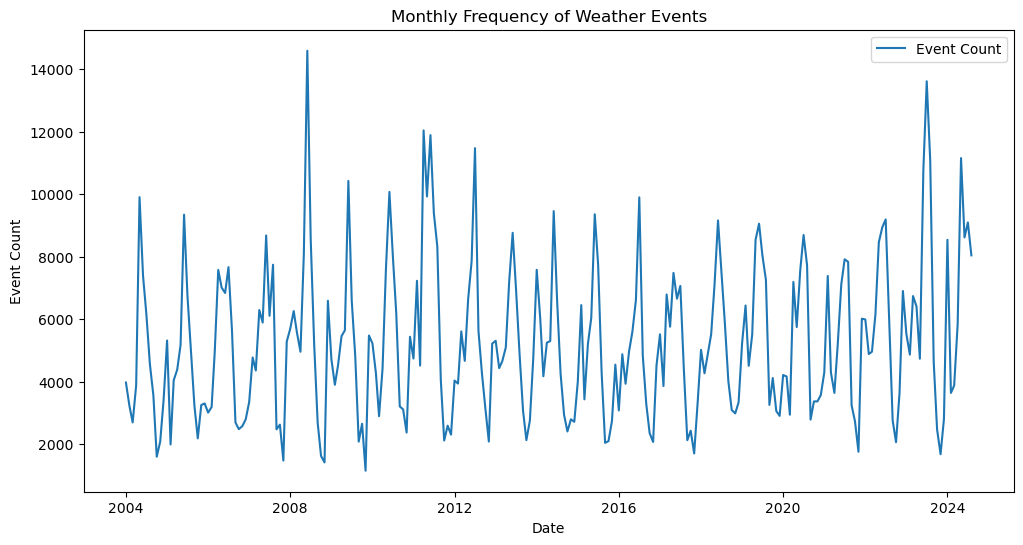

In [39]:
# Plotting the general frequency of total weather events to inspect for seasonality
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts['EVENT_COUNT'], label='Event Count')
plt.title('Monthly Frequency of Weather Events')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend()
plt.show()

Next, I am including a seasonal decomposition for each model to inspect the underlying components of the time series data—specifically, the trend, seasonality, and residuals. This helps better understand the data's underlying patterns, such as recurring seasonal effects and long-term trends, which are crucial for determining if a SARIMA model is suitable before proceeding. By separating the data into its key components, I can visually evaluate the presence of consistent seasonal patterns, long-term trends, and any irregular variations that may affect the model's performance.

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

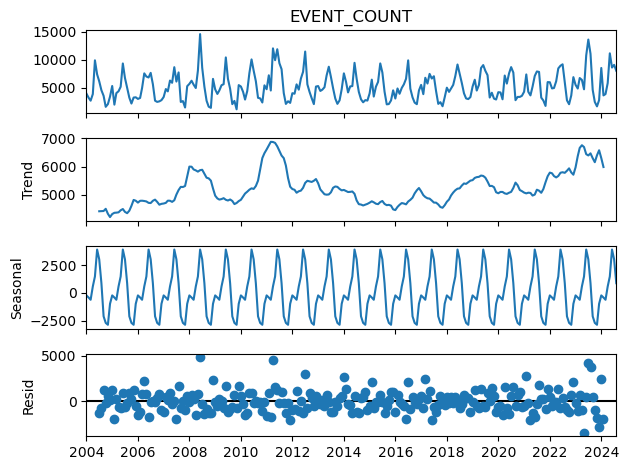

In [41]:
# Performing decomposition
decomposition = seasonal_decompose(monthly_counts['EVENT_COUNT'], model='additive')
decomposition.plot()
plt.show()

Now I will proceed with fitting the SARIMA model. I begin by initializing and fitting the model to the data, carefully choosing the seasonal and non-seasonal parameters that best capture the patterns in the time series. Once the model is fitted, I'll evaluate its performance by printing the model results to examine the significance and magnitude of the coefficients. I will then use plot_diagnostics to visually inspect the residuals, ensuring they are randomly distributed and do not exhibit any systematic patterns.

In [42]:
# Initializing the SARRIMA model
model = SARIMAX(monthly_counts['EVENT_COUNT'], 
                order=(1, 1, 1), 
                seasonal_order=(1, 1, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

C:\Users\krist\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\krist\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [43]:
# Fitting the model
results = model.fit()

# Viewing the summary of model results
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        EVENT_COUNT   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1926.354
Date:                            Fri, 20 Dec 2024   AIC                           3862.708
Time:                                    16:49:08   BIC                           3879.699
Sample:                                01-01-2004   HQIC                          3869.569
                                     - 08-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1439      0.068      2.121      0.034       0.011       0.277
ma.L1         -0.9476      0.030   

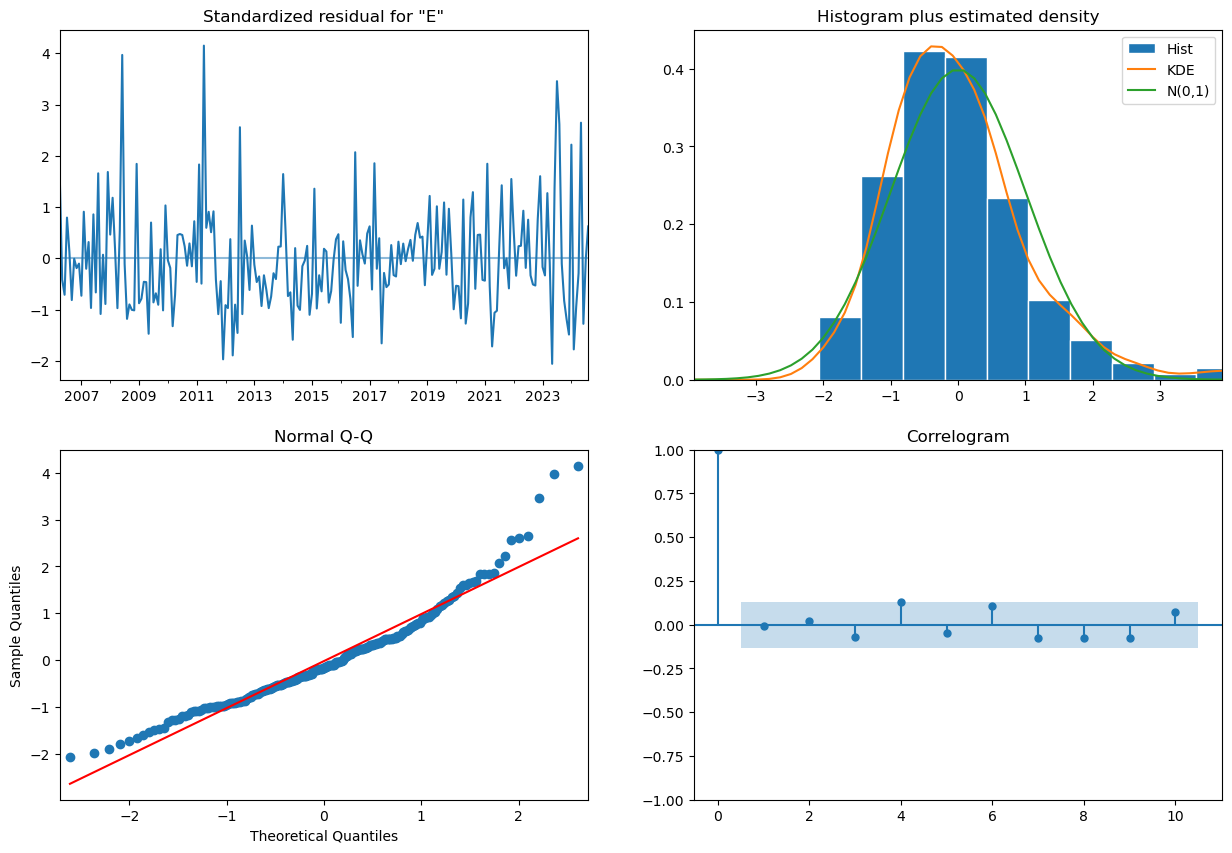

In [44]:
# Plotting diagnostics for the results of the model
results.plot_diagnostics(figsize=(15, 10))
plt.show()

Now that the model has been fit to the data, I will use it to forecast the total number of extreme weather events that will occur within the US each month over the next 12 months. The forecast and the confidence intervals around the forecasted numbers will be plotted alongside the historical data.

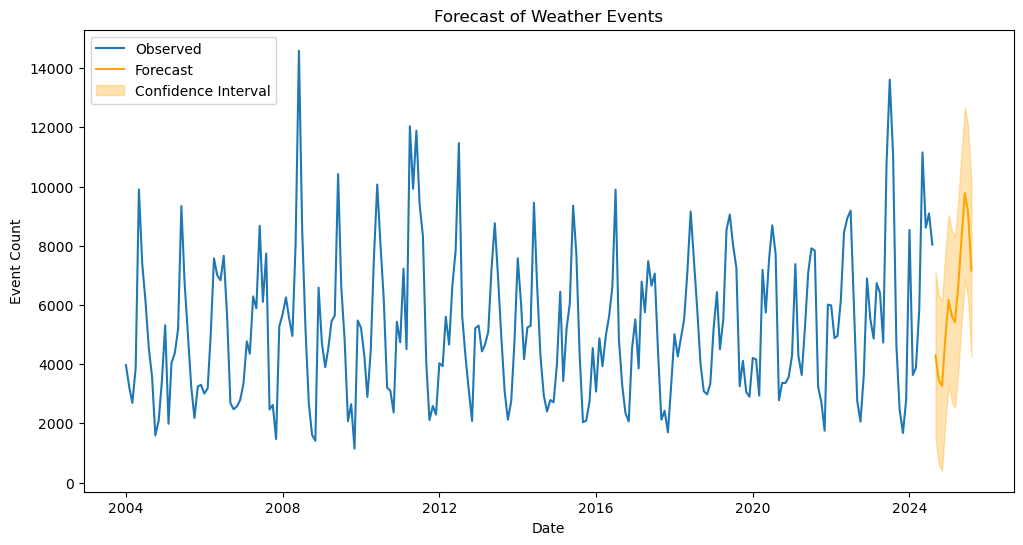

In [45]:
# Using the model to forecast occurrences of total extreme weather events over the next 12 months
forecast = results.get_forecast(steps=12)
forecast_index = pd.date_range(start=monthly_counts.index[-1], periods=12, freq='M')

# Adding in confidence intervals
forecast_ci = forecast.conf_int()

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(monthly_counts.index, monthly_counts['EVENT_COUNT'], label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='orange', alpha=0.3, label='Confidence Interval')
plt.title('Forecast of Weather Events')
plt.xlabel('Date')
plt.ylabel('Event Count')
plt.legend()
plt.show()

The previous steps will now be repeated almost identically for individual weather events - excessive heat and heat events, tornadoes, flash floods, and hurricanes/tropical storms. The same process for preprocessing, building the model, fitting the model, evaluating the model, and using the model to forecast the next 12 months will be used.

### Excessive Heat and Heat Modeling

In [46]:
# Getting monthly counts of heat/high heat-related events
heat_events = combined_data[combined_data['EVENT_TYPE'].isin(['Excessive Heat', 'Heat'])]
heat_events.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TOTAL_DAMAGE,TOTAL_FATALITIES,TOTAL_INJURIES,MONTH,DATE
3436,2004,1,3,15:00:00,2004,1,3,15:00:00,1165337,5381778,ALABAMA,1,2004,January,Heat,Z,24,JEFFERSON,BMX,03-JAN-04 15:00:00,CST,03-JAN-04 15:00:00,0,0,0,0,0.0,0.0,"AWOS,ASOS,MESONET,ETC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The afternoon high temperature measured at the...,PDS,0.0,0,0,1,2004-01-01
3437,2004,1,3,15:00:00,2004,1,3,15:00:00,1165338,5381779,ALABAMA,1,2004,January,Heat,Z,44,MONTGOMERY,BMX,03-JAN-04 15:00:00,CST,03-JAN-04 15:00:00,0,0,0,0,0.0,0.0,"AWOS,ASOS,MESONET,ETC",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The afternoon high temperature reading at Dann...,PDS,0.0,0,0,1,2004-01-01
6171,2004,3,8,14:00:00,2004,3,22,18:00:00,1166114,5384873,CALIFORNIA,6,2004,March,Heat,Z,91,SW S.J. VALLEY,HNX,08-MAR-04 14:00:00,PST,22-MAR-04 18:00:00,0,0,0,0,0.0,0.0,OFFICIAL NWS OBS.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Two of the three normally wettest months had e...,NaN,PDS,0.0,0,0,3,2004-03-01
6845,2004,4,25,13:00:00,2004,4,28,21:00:00,1166876,5387283,CALIFORNIA,6,2004,April,Heat,Z,97,TULARE CTY MTNS,HNX,25-APR-04 13:00:00,PST,28-APR-04 21:00:00,0,0,0,0,0.0,0.0,OFFICIAL NWS OBS.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,During the month of April the second of two wa...,NaN,PDS,0.0,0,0,4,2004-04-01
6846,2004,4,25,13:00:00,2004,4,28,21:00:00,1166876,5387284,CALIFORNIA,6,2004,April,Heat,Z,95,KERN CTY MTNS,HNX,25-APR-04 13:00:00,PST,28-APR-04 21:00:00,0,0,0,0,0.0,0.0,OFFICIAL NWS OBS.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,During the month of April the second of two wa...,NaN,PDS,0.0,0,0,4,2004-04-01


In [47]:
# Aggregating by year and month to count event occurrences
heat_event_counts = (
    heat_events.groupby(['YEAR', 'MONTH'])
    .size()
    .reset_index(name='EVENT_COUNT')
)

In [48]:
# Ensuring 'YEAR' and 'MONTH' are integers
heat_event_counts['YEAR'] = heat_event_counts['YEAR'].astype(int)
heat_event_counts['MONTH'] = heat_event_counts['MONTH'].astype(int)

In [49]:
# Creating a datetime index using 'YEAR' and 'MONTH'
heat_event_counts['DATE'] = pd.to_datetime(
    heat_event_counts[['YEAR', 'MONTH']].assign(DAY=1)
)

In [50]:
# Setting the index to the 'DATE' column
heat_event_counts.set_index('DATE', inplace=True)

# Resampling to monthly frequency to ensure consistent time intervals
heat_event_counts = heat_event_counts.resample('M').sum()

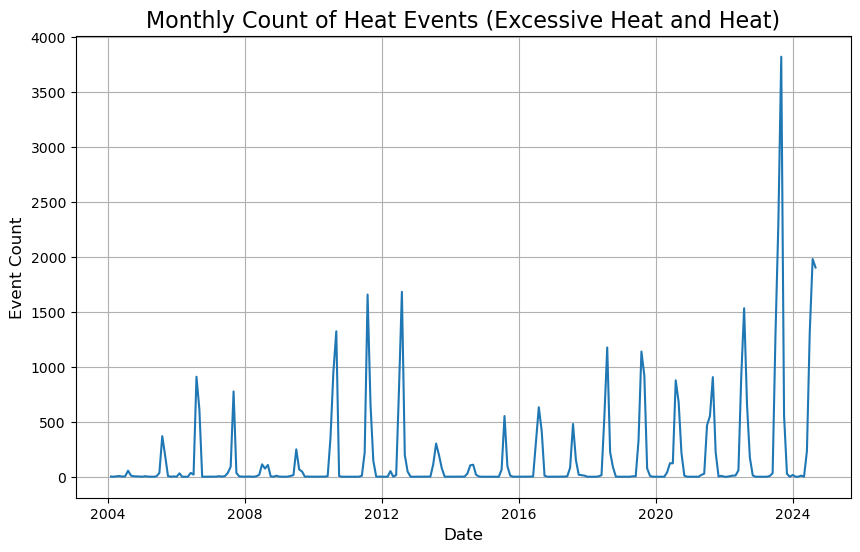

In [51]:
# Plotting the time series for monthly counts of heat related events
plt.figure(figsize=(10, 6))
plt.plot(heat_event_counts['EVENT_COUNT'],linestyle='-')
plt.title('Monthly Count of Heat Events (Excessive Heat and Heat)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.grid(True)
plt.show()

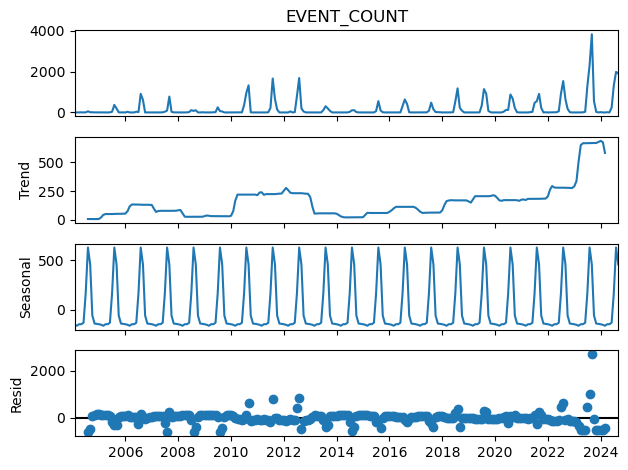

In [52]:
# Decomposing the time series
decomposition = seasonal_decompose(heat_event_counts['EVENT_COUNT'], model='additive')

# Plotting the decomposition
decomposition.plot()
plt.show()

In [53]:
# Initializing the SARIMA model
sarima_model = SARIMAX(
    heat_event_counts['EVENT_COUNT'],
    order=(1, 1, 1),           # ARIMA (p, d, q) terms
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, S) terms
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fitting the model
sarima_results = sarima_model.fit(disp=False)

# Printing the model summary
print(sarima_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        EVENT_COUNT   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1568.896
Date:                            Fri, 20 Dec 2024   AIC                           3147.793
Time:                                    16:49:12   BIC                           3164.783
Sample:                                01-31-2004   HQIC                          3154.653
                                     - 08-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3727      0.073      5.117      0.000       0.230       0.515
ma.L1         -1.0272      0.051   

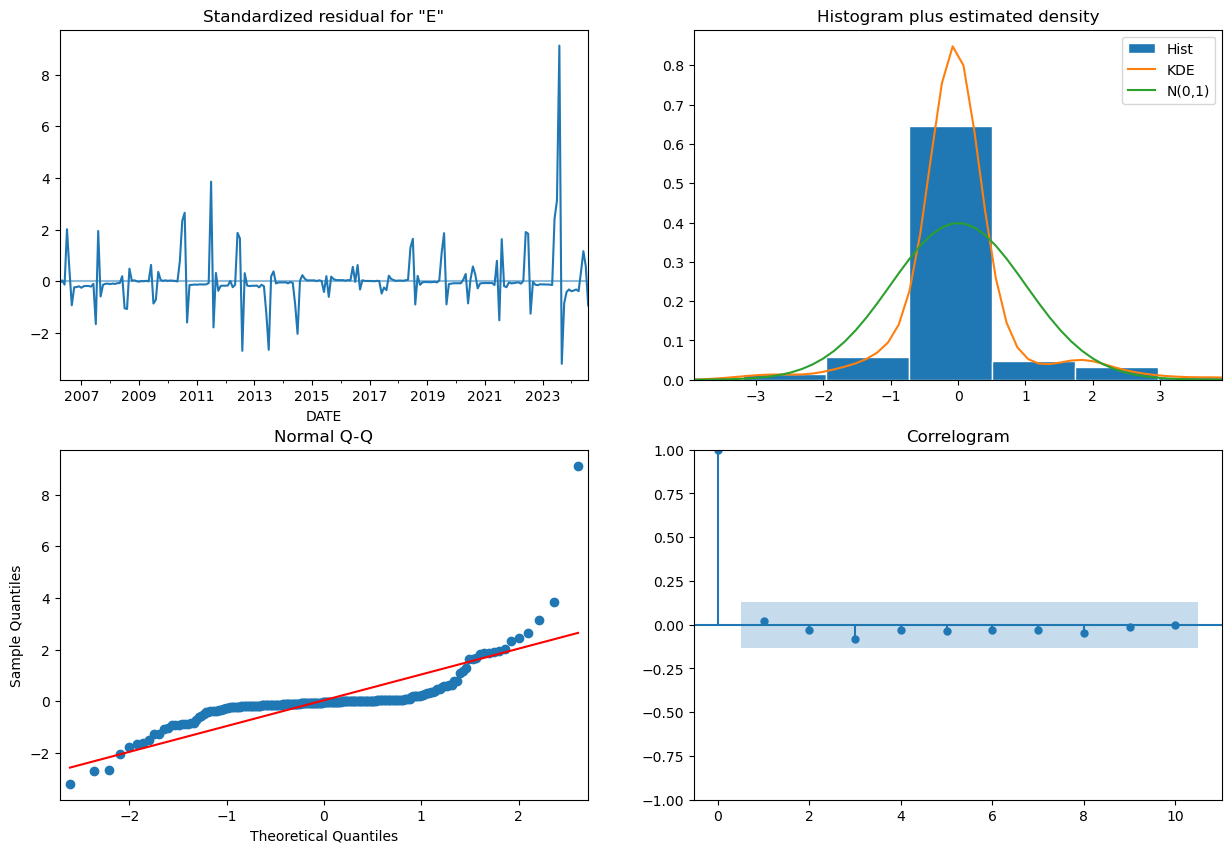

In [54]:
# Plotting the diagnostics
sarima_results.plot_diagnostics(figsize=(15, 10))
plt.show()

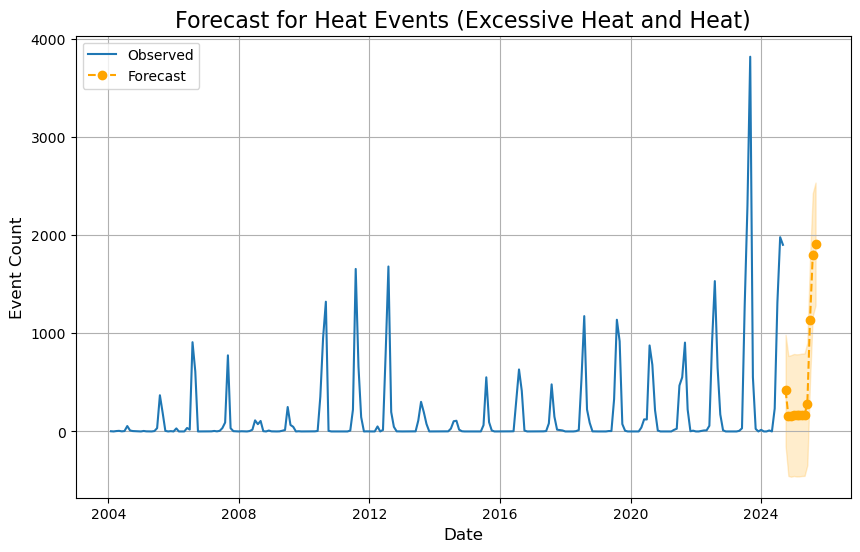

In [55]:
# Forecasting future values
forecast = sarima_results.get_forecast(steps=12)
forecast_index = pd.date_range(
    start=heat_event_counts.index[-1] + pd.DateOffset(months=1), 
    periods=12, 
    freq='M'
)

# Extracting predicted values and confidence intervals
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(heat_event_counts['EVENT_COUNT'], label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='orange', linestyle='--', marker='o')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.title('Forecast for Heat Events (Excessive Heat and Heat)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Tornado Modeling

In [56]:
# Getting monthly counts of tornado-related events
tornado_events = combined_data[combined_data['EVENT_TYPE'].isin(['Tornado'])]
tornado_events.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TOTAL_DAMAGE,TOTAL_FATALITIES,TOTAL_INJURIES,MONTH,DATE
31,2004,7,24,14:30:00,2004,7,24,14:30:00,2152355,5432062,NEVADA,32,2004,July,Tornado,C,31,WASHOE,REV,24-JUL-04 14:30:00,PST,24-JUL-04 14:30:00,0,0,0,0,0.0,0.0,GENERAL PUBLIC,NaN,NaN,NaN,NaN,F0,0.1,200.0,NaN,NaN,NaN,NaN,8.0,N,RENO,8.0,N,RENO,NaN,NaN,NaN,NaN,NaN,"An F0 tornado was spotted in Cold Springs, nor...",PDS,0.0,0,0,7,2004-07-01
114,2004,12,29,12:10:00,2004,12,29,12:12:00,1182775,5430397,CALIFORNIA,6,2004,December,Tornado,C,97,SONOMA,MTR,29-DEC-04 12:10:00,PST,29-DEC-04 12:12:00,0,0,0,0,3000.0,0.0,LAW ENFORCEMENT,NaN,NaN,NaN,NaN,F0,0.2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,SANTA ROSA,NaN,NaN,SANTA ROSA,38.45000,-122.70000,38.45000,-122.70000,NaN,Brief F0 tornado touchdown in the NW portion o...,PDS,3000.0,0,0,12,2004-12-01
216,2004,12,9,05:38:00,2004,12,9,05:39:00,1182727,5430610,MISSISSIPPI,28,2004,December,Tornado,C,69,KEMPER,JAN,09-DEC-04 05:38:00,CST,09-DEC-04 05:39:00,0,0,0,0,5000.0,0.0,NWS STORM SURVEY,NaN,NaN,NaN,NaN,F0,0.2,50.0,NaN,NaN,NaN,NaN,2.0,SW,DE KALB,2.0,SW,DE KALB,32.23333,-89.43333,32.28333,-89.38333,NaN,This weak tornado downed several trees when it...,PDS,5000.0,0,0,12,2004-12-01
329,2004,12,7,10:15:00,2004,12,7,10:18:00,1182686,5430497,INDIANA,18,2004,December,Tornado,C,31,DECATUR,IND,07-DEC-04 10:15:00,EST,07-DEC-04 10:18:00,0,0,0,0,15000.0,0.0,NWS STORM SURVEY,NaN,NaN,NaN,NaN,F0,1.5,75.0,NaN,NaN,NaN,NaN,2.0,SW,SANDUSKY,2.0,SW,SANDUSKY,39.40000,-85.50000,39.41667,-85.48333,A few strong storms moved through southeastern...,"On Tuesday 7 December 2004, a rare December to...",PDS,15000.0,0,0,12,2004-12-01
748,2004,2,27,23:30:00,2004,2,28,00:30:00,1183227,5431177,HAWAII,15,2004,February,Tornado,C,1,HAWAII,HFO,27-FEB-04 23:30:00,HST,28-FEB-04 00:30:00,0,0,0,0,0.0,0.0,NWS STORM SURVEY,NaN,NaN,NaN,NaN,F0,5.0,25.0,NaN,NaN,NaN,NaN,2.0,SE,PAHALA,2.0,SE,PAHALA,19.18333,-155.46667,19.41667,-155.23333,NaN,A tornado touched down in the Kau District on ...,PDS,0.0,0,0,2,2004-02-01


In [57]:
# Aggregating by year and month to count event occurrences
tornado_event_counts = (
    tornado_events.groupby(['YEAR', 'MONTH'])
    .size()
    .reset_index(name='EVENT_COUNT')
)

In [58]:
# Ensuring 'YEAR' and 'MONTH' are integers
tornado_event_counts['YEAR'] = tornado_event_counts['YEAR'].astype(int)
tornado_event_counts['MONTH'] = tornado_event_counts['MONTH'].astype(int)

In [59]:
# Creating a datetime index using 'YEAR' and 'MONTH'
tornado_event_counts['DATE'] = pd.to_datetime(
    tornado_event_counts[['YEAR', 'MONTH']].assign(DAY=1)
)

In [60]:
# Setting the index to the 'DATE' column
tornado_event_counts.set_index('DATE', inplace=True)

# Resampling to monthly frequency to ensure consistent time intervals
tornado_event_counts = tornado_event_counts.resample('M').sum()

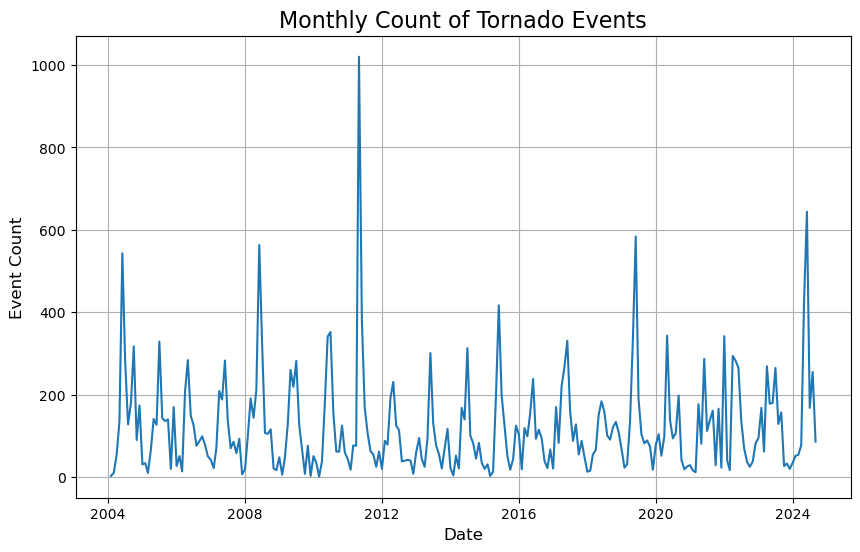

In [61]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(tornado_event_counts['EVENT_COUNT'], linestyle='-')
plt.title('Monthly Count of Tornado Events', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.grid(True)
plt.show()

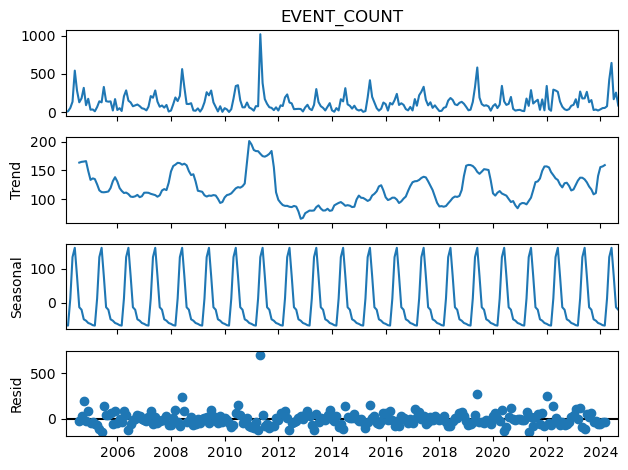

In [62]:
# Decomposing the time series
decomposition = seasonal_decompose(tornado_event_counts['EVENT_COUNT'], model='additive')

# Plotting the decomposition
decomposition.plot()
plt.show()

In [63]:
# Initializing the SARIMA model
sarima_model_tornado = SARIMAX(
    tornado_event_counts['EVENT_COUNT'],
    order=(1, 1, 1),           # ARIMA (p, d, q) terms
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, S) terms
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fitting the model
sarima_results_tornado = sarima_model_tornado.fit(disp=False)

# Printing the summary
print(sarima_results_tornado.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        EVENT_COUNT   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1327.675
Date:                            Fri, 20 Dec 2024   AIC                           2665.350
Time:                                    16:49:16   BIC                           2682.340
Sample:                                01-31-2004   HQIC                          2672.210
                                     - 08-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1143      0.096      1.197      0.231      -0.073       0.302
ma.L1         -0.9777      0.043   

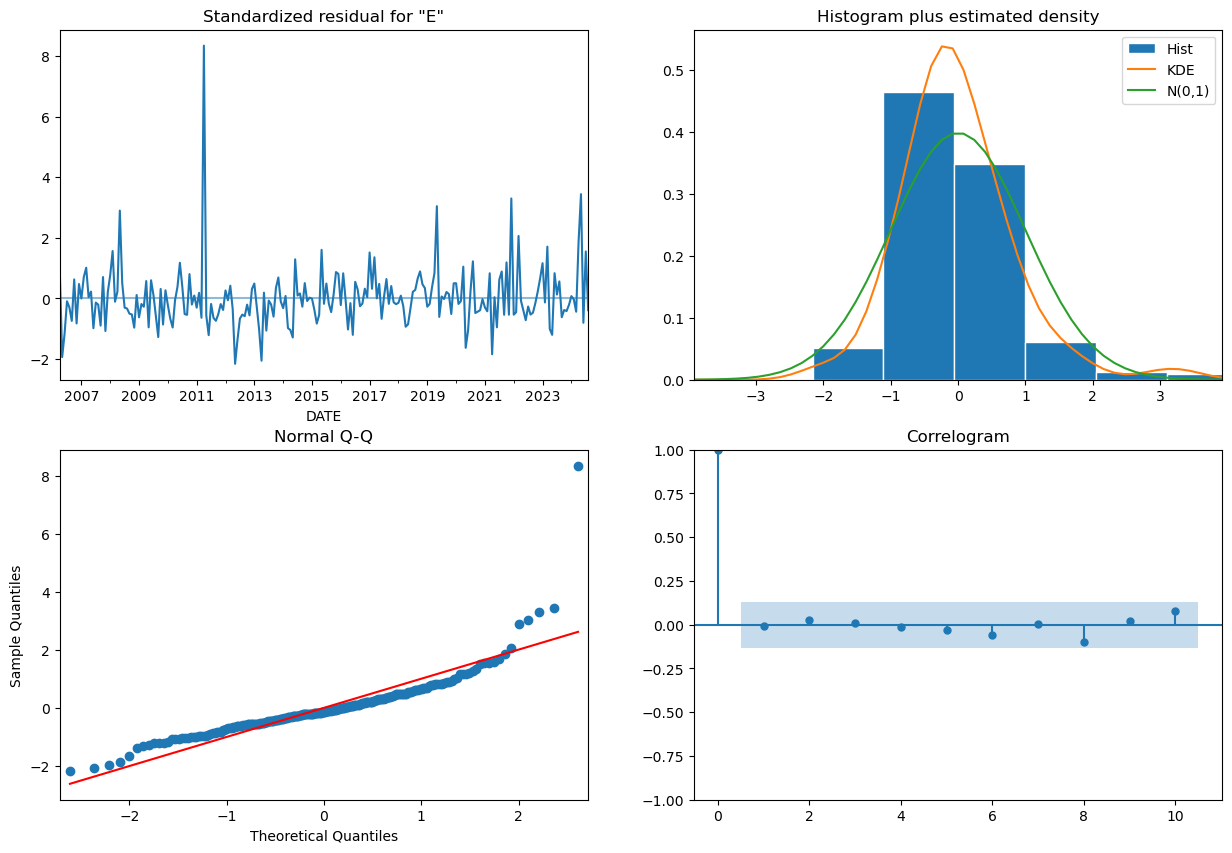

In [64]:
# Plotting the diagnostics
sarima_results_tornado.plot_diagnostics(figsize=(15, 10))
plt.show()

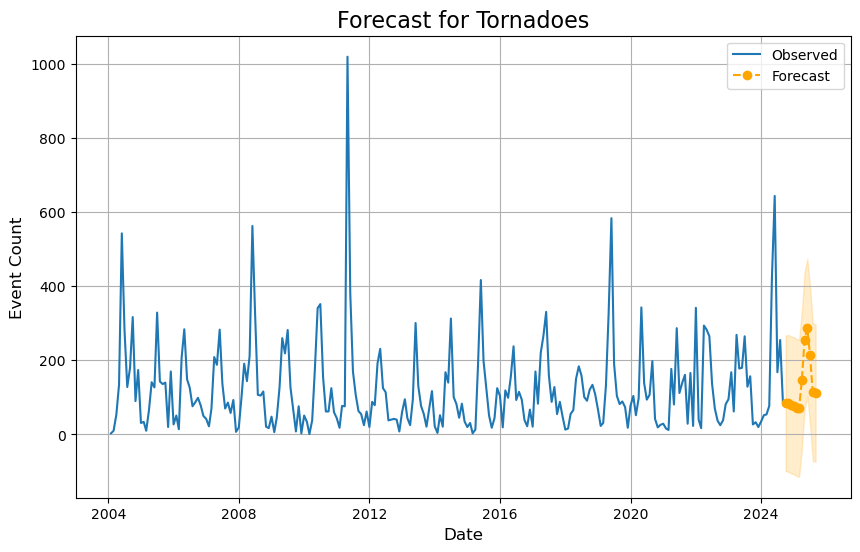

In [65]:
# Forecastting future values
forecast_tornado = sarima_results_tornado.get_forecast(steps=12)
forecast_index_tornado = pd.date_range(
    start=tornado_event_counts.index[-1] + pd.DateOffset(months=1), 
    periods=12, 
    freq='M'
)

# Extracting predicted values and confidence intervals
forecast_values_tornado = forecast_tornado.predicted_mean
forecast_ci_tornado = forecast_tornado.conf_int()

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(tornado_event_counts['EVENT_COUNT'], label='Observed')
plt.plot(forecast_index_tornado, forecast_values_tornado, label='Forecast', color='orange', linestyle='--', marker='o')
plt.fill_between(forecast_index_tornado, forecast_ci_tornado.iloc[:, 0], forecast_ci_tornado.iloc[:, 1], color='orange', alpha=0.2)
plt.title('Forecast for Tornadoes', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Huricane Modeling

In [66]:
# Getting monthly counts of hurricane/tropical storm events
hurricane_events = combined_data[combined_data['EVENT_TYPE'].isin(['Hurricane', 'Tropical Storm', 'Tropical Depression', 
                                                                   'Hurricane (Typhoon)', 'Marine Tropical Storm', 
                                                                   'Marine Hurricane/Typhoon', 'Marine Tropical Depression'])]
hurricane_events.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TOTAL_DAMAGE,TOTAL_FATALITIES,TOTAL_INJURIES,MONTH,DATE
94,2004,10,9,15:00:00,2004,10,10,18:00:00,1187101,5430987,LOUISIANA,22,2004,October,Tropical Storm,Z,61,UPPER JEFFERSON,LIX,09-OCT-04 15:00:00,CST,10-OCT-04 18:00:00,0,0,0,0,2000.0,0.0,NWS STORM SURVEY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tropical Storm Matthew developed from a tropic...,NaN,PDS,2000.0,0,0,10,2004-10-01
95,2004,10,9,15:00:00,2004,10,10,18:00:00,1187101,5430988,LOUISIANA,22,2004,October,Tropical Storm,Z,59,UPPER LAFOURCHE,LIX,09-OCT-04 15:00:00,CST,10-OCT-04 18:00:00,0,0,0,0,4000.0,0.0,OFFICIAL NWS OBS.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tropical Storm Matthew developed from a tropic...,NaN,PDS,4000.0,0,0,10,2004-10-01
96,2004,10,9,15:00:00,2004,10,10,18:00:00,1187101,5430989,LOUISIANA,22,2004,October,Tropical Storm,Z,63,UPPER PLAQUEMINES,LIX,09-OCT-04 15:00:00,CST,10-OCT-04 18:00:00,0,0,0,0,1000.0,0.0,OFFICIAL NWS OBS.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tropical Storm Matthew developed from a tropic...,NaN,PDS,1000.0,0,0,10,2004-10-01
97,2004,10,9,15:00:00,2004,10,10,18:00:00,1187101,5430990,LOUISIANA,22,2004,October,Tropical Storm,Z,64,UPPER ST. BERNARD,LIX,09-OCT-04 15:00:00,CST,10-OCT-04 18:00:00,0,0,0,0,1000.0,0.0,OFFICIAL NWS OBS.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tropical Storm Matthew developed from a tropic...,NaN,PDS,1000.0,0,0,10,2004-10-01
159,2004,9,15,10:00:00,2004,9,16,06:00:00,1187087,5432676,LOUISIANA,22,2004,September,Hurricane (Typhoon),Z,69,LOWER PLAQUEMINES,LIX,15-SEP-04 10:00:00,CST,16-SEP-04 06:00:00,0,0,0,0,8600000.0,0.0,EMERGENCY MANAGER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hurricane Ivan moved steadily northward across...,NaN,PDS,8600000.0,0,0,9,2004-09-01


In [67]:
hurricane_events.shape

(8175, 58)

In [68]:
# Aggregating by year and month to count event occurrences
hurricane_event_counts = (
    hurricane_events.groupby(['YEAR', 'MONTH'])
    .size()
    .reset_index(name='EVENT_COUNT')
)

In [69]:
# Ensuring 'YEAR' and 'MONTH' are integers
hurricane_event_counts['YEAR'] = hurricane_event_counts['YEAR'].astype(int)
hurricane_event_counts['MONTH'] = hurricane_event_counts['MONTH'].astype(int)

In [70]:
# Creating a datetime index using 'YEAR' and 'MONTH'
hurricane_event_counts['DATE'] = pd.to_datetime(
    hurricane_event_counts[['YEAR', 'MONTH']].assign(DAY=1)
)

In [71]:
# Setting the index to the 'DATE' column
hurricane_event_counts.set_index('DATE', inplace=True)

# Resampling to monthly frequency to ensure consistent time intervals
hurricane_event_counts = hurricane_event_counts.resample('M').sum()

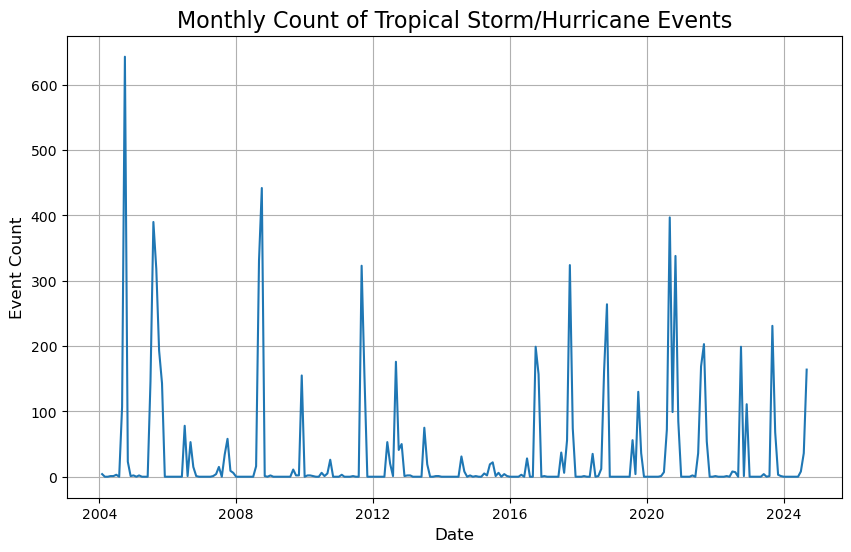

In [72]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(hurricane_event_counts['EVENT_COUNT'], linestyle='-')
plt.title('Monthly Count of Tropical Storm/Hurricane Events', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.grid(True)
plt.show()

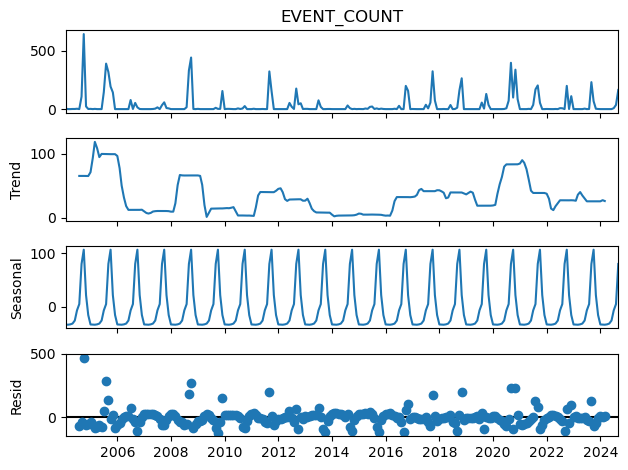

In [73]:
# Decomposing the time series
decomposition_hurricane = seasonal_decompose(hurricane_event_counts['EVENT_COUNT'], model='additive')

# Plotting the decomposition
decomposition_hurricane.plot()
plt.show()

In [74]:
# Initializing the SARIMA model
sarima_model_hurricane = SARIMAX(
    hurricane_event_counts['EVENT_COUNT'],
    order=(1, 1, 1),           # ARIMA (p, d, q) terms
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, S) terms
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fitting the model
sarima_results_hurricane = sarima_model_hurricane.fit(disp=False)

# Printing the summary
print(sarima_results_hurricane.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        EVENT_COUNT   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1258.718
Date:                            Fri, 20 Dec 2024   AIC                           2527.436
Time:                                    16:49:20   BIC                           2544.427
Sample:                                01-31-2004   HQIC                          2534.296
                                     - 08-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2652      0.053      5.026      0.000       0.162       0.369
ma.L1         -0.9690      0.033   

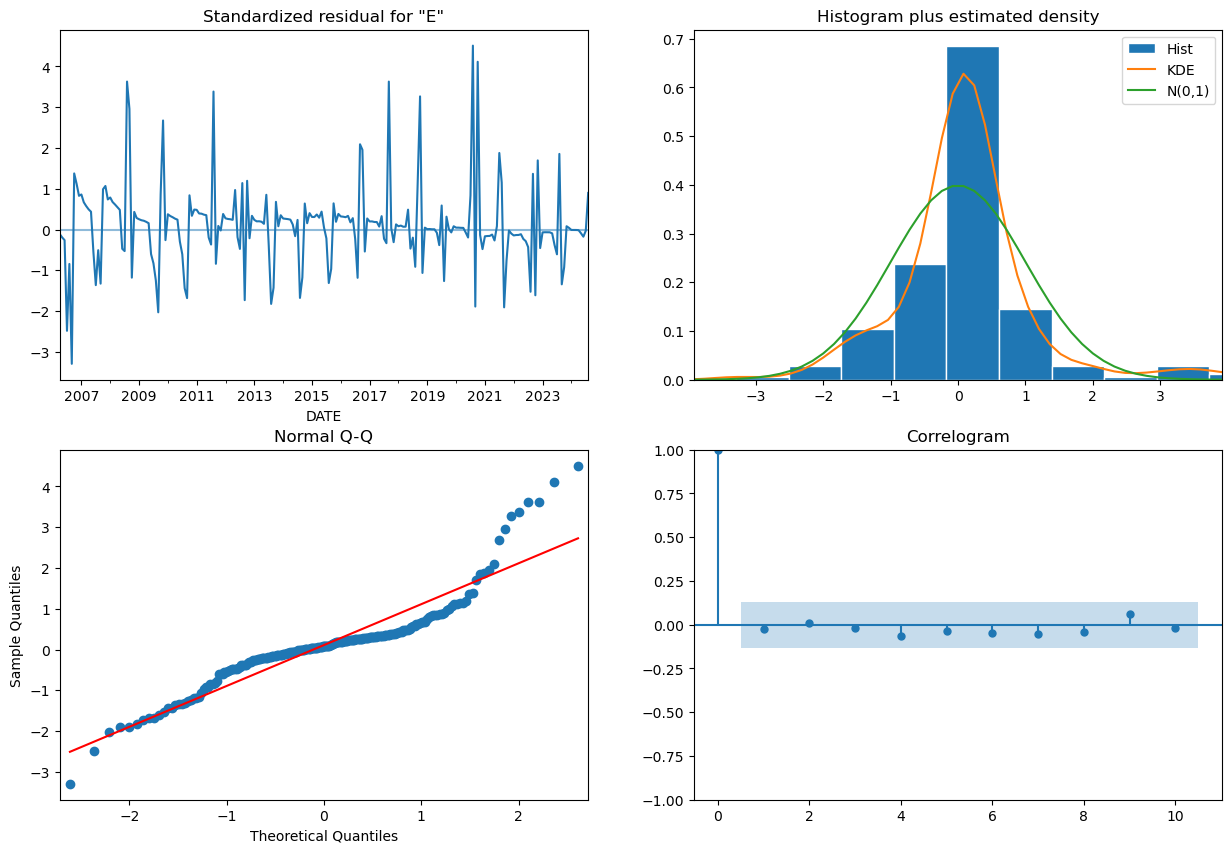

In [75]:
# Plotting the diagnostics
sarima_results_hurricane.plot_diagnostics(figsize=(15, 10))
plt.show()

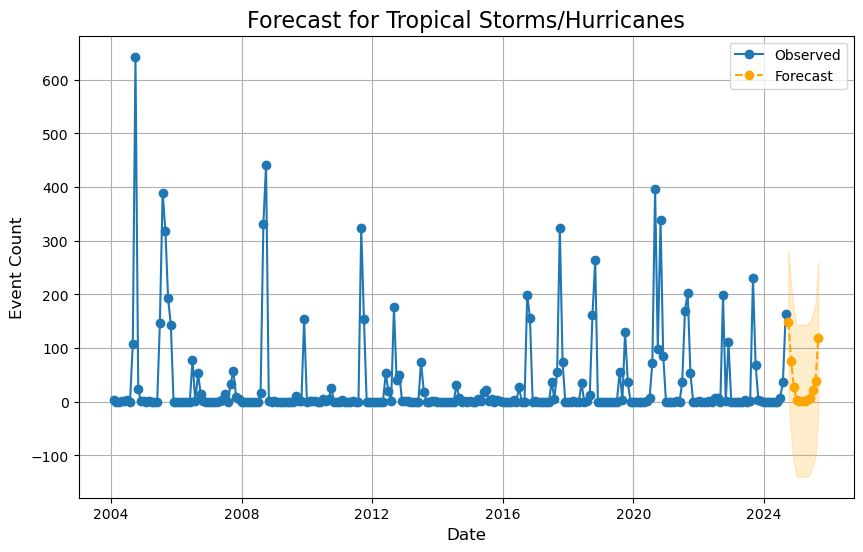

In [76]:
# Forecasting future values
forecast_hurricane = sarima_results_hurricane.get_forecast(steps=12)
forecast_index_hurricane = pd.date_range(
    start=hurricane_event_counts.index[-1] + pd.DateOffset(months=1), 
    periods=12, 
    freq='M'
)

# Extracting predicted values and confidence intervals
forecast_values_hurricane = forecast_hurricane.predicted_mean
forecast_ci_hurricane = forecast_hurricane.conf_int()

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(hurricane_event_counts['EVENT_COUNT'], label='Observed', marker='o')
plt.plot(forecast_index_hurricane, forecast_values_hurricane, label='Forecast', color='orange', linestyle='--', marker='o')
plt.fill_between(forecast_index_hurricane, forecast_ci_hurricane.iloc[:, 0], forecast_ci_hurricane.iloc[:, 1], color='orange', alpha=0.2)
plt.title('Forecast for Tropical Storms/Hurricanes', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

### Flash Flood Modeling

In [77]:
# Getting monthly counts of flash flood events
flood_events = combined_data[combined_data['EVENT_TYPE'].isin(['Flash Flood'])]
flood_events.head()

,BEGIN_YEAR,BEGIN_MONTH,BEGIN_DAY,BEGIN_TIME,END_YEAR,END_MONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,TOTAL_DAMAGE,TOTAL_FATALITIES,TOTAL_INJURIES,MONTH,DATE
34,2004,8,14,18:00:00,2004,8,14,18:55:00,2152358,5432065,NEVADA,32,2004,August,Flash Flood,C,29,STOREY,REV,14-AUG-04 18:00:00,PST,14-AUG-04 18:55:00,0,0,0,0,0.0,0.0,NWS EMPLOYEE(OFF DUTY),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NORTH CENTRAL PORTION,NaN,NaN,NORTH CENTRAL PORTION,NaN,NaN,NaN,NaN,NaN,"As a result of heavy rainfall, a total of 6 in...",PDS,0.0,0,0,8,2004-08-01
42,2004,12,7,05:45:00,2004,12,7,08:00:00,1182786,5430508,TENNESSEE,47,2004,December,Flash Flood,C,169,TROUSDALE,OHX,07-DEC-04 05:45:00,CST,07-DEC-04 08:00:00,0,0,0,0,1000.0,0.0,LAW ENFORCEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HARTSVILLE,NaN,NaN,HARTSVILLE,NaN,NaN,NaN,NaN,NaN,Highway 141N reported flooding.,PDS,1000.0,0,0,12,2004-12-01
44,2004,12,7,06:15:00,2004,12,7,08:00:00,1182786,5430510,TENNESSEE,47,2004,December,Flash Flood,C,117,MARSHALL,OHX,07-DEC-04 06:15:00,CST,07-DEC-04 08:00:00,0,0,0,0,1000.0,0.0,LAW ENFORCEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LEWISBURG,NaN,NaN,LEWISBURG,NaN,NaN,NaN,NaN,NaN,Reports of Old Columbia Road and Yell Road wer...,PDS,1000.0,0,0,12,2004-12-01
45,2004,12,7,06:30:00,2004,12,7,08:30:00,1182786,5430511,TENNESSEE,47,2004,December,Flash Flood,C,15,CANNON,OHX,07-DEC-04 06:30:00,CST,07-DEC-04 08:30:00,0,0,0,0,1000.0,0.0,TRAINED SPOTTER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AUBURNTOWN,NaN,NaN,AUBURNTOWN,NaN,NaN,NaN,NaN,NaN,Bridge Road was flooded.,PDS,1000.0,0,0,12,2004-12-01
46,2004,12,7,06:50:00,2004,12,7,09:30:00,1182786,5430512,TENNESSEE,47,2004,December,Flash Flood,C,141,PUTNAM,OHX,07-DEC-04 06:50:00,CST,07-DEC-04 09:30:00,0,0,0,0,1000.0,0.0,LAW ENFORCEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BAXTER,NaN,NaN,BAXTER,NaN,NaN,NaN,NaN,NaN,High water was over several roads.,PDS,1000.0,0,0,12,2004-12-01


In [78]:
# Aggregating by year and month to count event occurrences
flood_event_counts = (
    flood_events.groupby(['YEAR', 'MONTH'])
    .size()
    .reset_index(name='EVENT_COUNT')
)

In [79]:
# Ensuring 'YEAR' and 'MONTH' are integers
flood_event_counts['YEAR'] = flood_event_counts['YEAR'].astype(int)
flood_event_counts['MONTH'] = flood_event_counts['MONTH'].astype(int)

In [80]:
# Creating a datetime index using 'YEAR' and 'MONTH'
flood_event_counts['DATE'] = pd.to_datetime(
    flood_event_counts[['YEAR', 'MONTH']].assign(DAY=1)
)

In [81]:
# Setting the index to the 'DATE' column
flood_event_counts.set_index('DATE', inplace=True)

# Resampling to monthly frequency to ensure consistent time intervals
flood_event_counts = flood_event_counts.resample('M').sum()

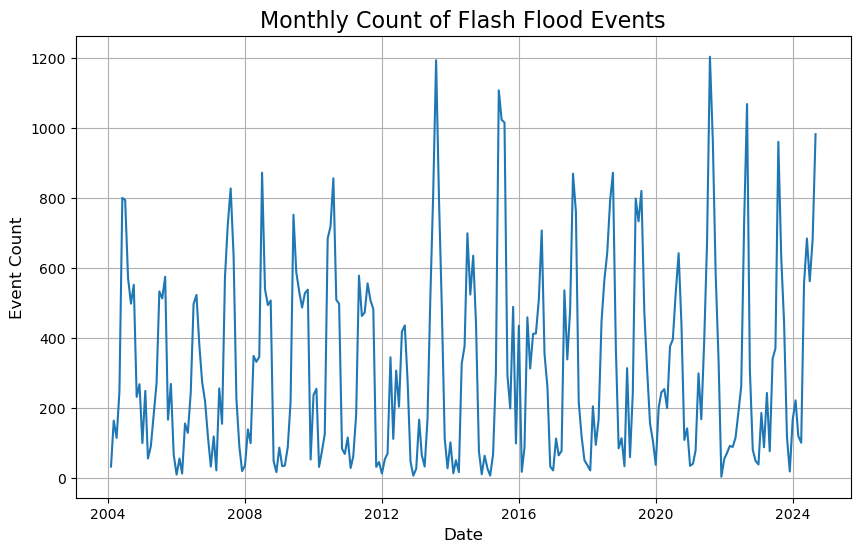

In [82]:
# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(flood_event_counts['EVENT_COUNT'], linestyle='-')
plt.title('Monthly Count of Flash Flood Events', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.grid(True)
plt.show()

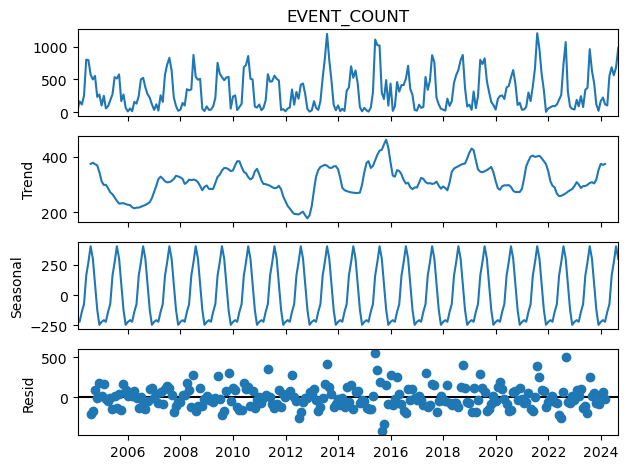

In [83]:
# Decomposing the time series
decomposition_flood = seasonal_decompose(flood_event_counts['EVENT_COUNT'], model='additive')

# Plotting the decomposition
decomposition_flood.plot()
plt.show()

In [84]:
# Initializing the SARIMA model
sarima_model_flood = SARIMAX(
    flood_event_counts['EVENT_COUNT'],
    order=(1, 1, 1),           # ARIMA (p, d, q) terms
    seasonal_order=(1, 1, 1, 12),  # Seasonal (P, D, Q, S) terms
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fitting the model
sarima_results_flood = sarima_model_flood.fit(disp=False)

# Printing the summary
print(sarima_results_flood.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        EVENT_COUNT   No. Observations:                  248
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1440.539
Date:                            Fri, 20 Dec 2024   AIC                           2891.079
Time:                                    16:49:24   BIC                           2908.070
Sample:                                01-31-2004   HQIC                          2897.939
                                     - 08-31-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2890      0.059      4.870      0.000       0.173       0.405
ma.L1         -1.0000      0.153   

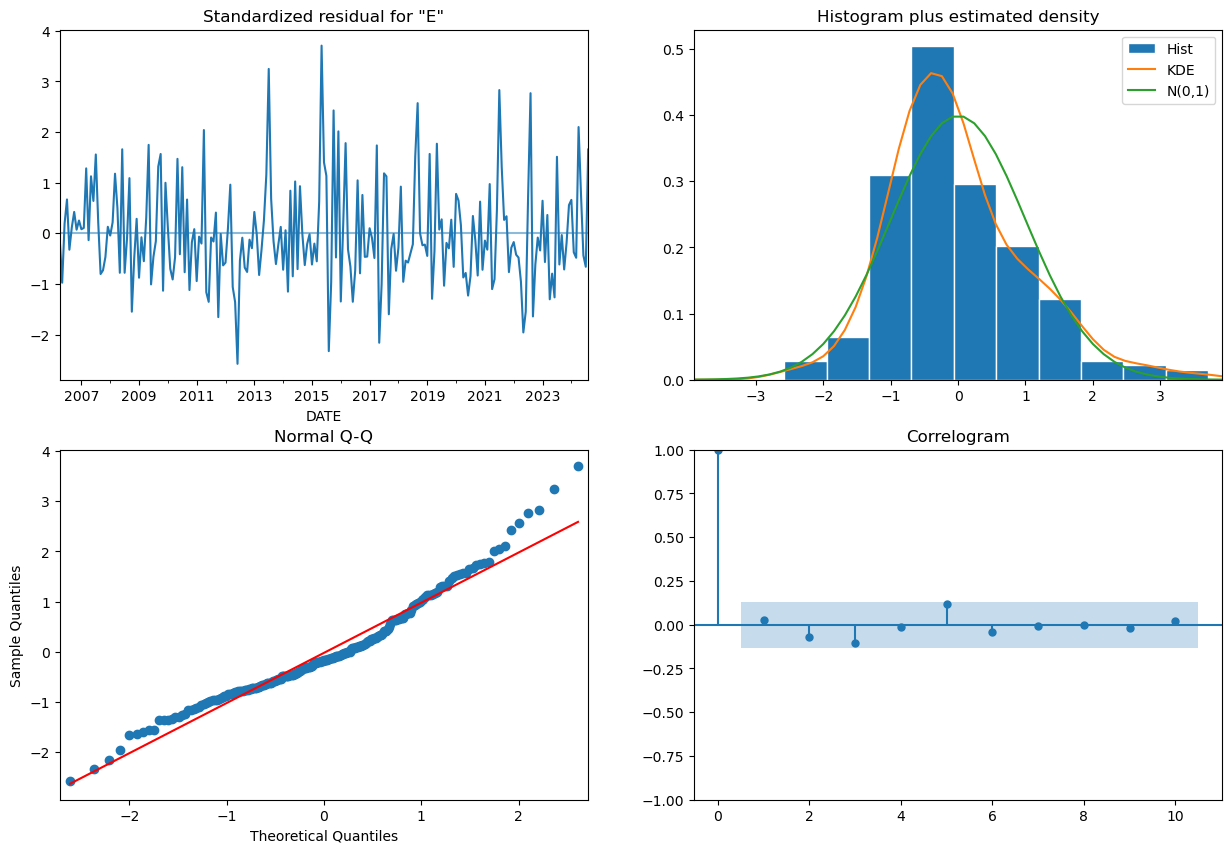

In [85]:
# Plotting the diagnostics
sarima_results_flood.plot_diagnostics(figsize=(15, 10))
plt.show()

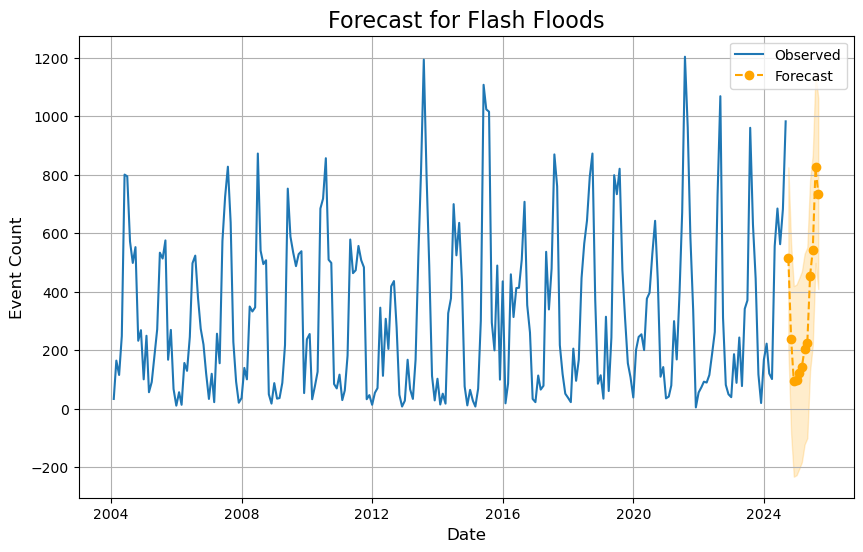

In [86]:
# Forecasting future values
forecast_flood = sarima_results_flood.get_forecast(steps=12)
forecast_index_flood = pd.date_range(
    start=flood_event_counts.index[-1] + pd.DateOffset(months=1), 
    periods=12, 
    freq='M'
)

# Extracting predicted values and confidence intervals
forecast_values_flood = forecast_flood.predicted_mean
forecast_ci_flood = forecast_flood.conf_int()

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(flood_event_counts['EVENT_COUNT'], label='Observed')
plt.plot(forecast_index_flood, forecast_values_flood, label='Forecast', color='orange', linestyle='--', marker='o')
plt.fill_between(forecast_index_flood, forecast_ci_flood.iloc[:, 0], forecast_ci_flood.iloc[:, 1], color='orange', alpha=0.2)
plt.title('Forecast for Flash Floods', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

## Results and Conclusions

#### Excessive Heat/Heat-Related Extreme Weather Events
The SARIMA model for excessive heat/heat events demonstrates a good fit, capturing key seasonal patterns and trends. The Ljung-Box test (p = 0.89) indicates no significant autocorrelation in the residuals, supporting the model’s adequacy. However, the Jarque-Bera test (p = 0.00) reveals some non-normality in the residuals, with positive skew and high kurtosis, suggesting the presence of outliers or extreme events (full model evaluation metrics available in Appendix A). Despite this, the model provides a strong basis for forecasting future occurrences of extreme heat events, though further refinement may be necessary to better address non-normal residuals.

#### Tornadoes
For the tornado model, the SARIMA model showed strong performance in terms of autocorrelation, as indicated by the Ljung-Box (Q) test which returned a high p-value of 0.91. This suggests that the model adequately captures the temporal dependencies in the frequency of tornado event occurrences. However, the Jarque-Bera (JB) test produced a very low p-value of 0.00, indicating that the residuals are not normally distributed (full model evaluation metrics available in Appendix B). This suggests that the model may not fully account for the distribution of the data, particularly in handling skewness and kurtosis. Overall, while the model effectively captures the temporal structure of tornado events, further refinement may be needed to better capture the distributional characteristics of the residuals.

#### Hurricanes, Tropical Storms, & Tropical Depressions
The SARIMA model for hurricanes, tropical storms, and tropical depressions demonstrates solid performance in modeling the temporal dynamics of event counts. The Ljung-Box (Q) test, with a p-value of 0.72, indicates no significant autocorrelation remaining in the residuals, suggesting that the model adequately captures the time dependencies in the data (full model evaluation metrics available in Appendix C). However, again we see the Jarque-Bera (JB) test returning a low p-value of 0.00, indicating non-normality in the residuals with notable skewness (1.02) and a high kurtosis (7.53). 

#### Flash Floods
Last, the SARIMA model for flash floods demonstrates a strong fit, with the Ljung-Box (Q) test yielding a p-value of 0.66, indicating no significant autocorrelation in the residuals. This suggests that the model is effectively capturing the time series dynamics. However, similar to the previous three models, the Jarque-Bera (JB) test shows a p-value of 0.00, pointing to deviations from normality, including mild skewness (0.76) and moderate kurtosis (4.05) (full model evaluation metrics available in Appendix D). While the model performs well in addressing autocorrelation, the non-normality of residuals could be improved for a better fit. Despite this, the model remains useful for forecasting flash flood events.

#### Conclusions and Implementation
This analysis successfully applied SARIMA models to forecast extreme weather events with significant impacts to humans, including heatwaves, tornadoes, hurricanes, and flash floods. The models generally performed well, with residual diagnostics indicating that autocorrelation was adequately captured. However, all models showed evidence of non-normal residuals, particularly for certain event types, which may require further refinement. These results highlight the potential for SARIMA in predicting extreme weather patterns, which can inform both mitigation strategies and resource allocation for emergency preparedness.
With further refinement, the models can be used to guide proactive measures in areas most vulnerable to these events. Forecasts from the models could help local governments and emergency agencies allocate resources more efficiently, plan for infrastructure needs, and prioritize public safety initiatives. Additionally, improving model accuracy by addressing residual issues could enhance the reliability of future predictions, making them more actionable in real-world scenarios.

## Future Uses, Additional Applications, and Recommendations
Future applications of this modeling approach could be enhanced by incorporating additional environmental data, such as temperature, precipitation, and atmospheric pressure, which may offer deeper insights into the drivers of extreme weather events. The use of a SARIMAX model as opposed to a SARIMA would allow for the inclusion of exogenous variables which could significantly improve the model’s predictive accuracy by considering external factors (especially since environmental factors play a huge role in weather patterns). Expanding the time series data beyond the current 20-year limit, once computational limitations are addressed, would allow for more comprehensive trend analysis.

 In practice, this model could be used by disaster management agencies and local governments to better prepare for and mitigate the impacts of extreme weather events. Further research could also explore the application of this methodology to other extreme weather events that were not covered in this analysis focused on weather events with the greatest threat to human life and the economy. Another key avenue for future research could be incorporating geographical analysis using spatial data to identify regions most at risk for specific types of extreme weather. This could help allocate resources more efficiently and develop tailored strategies for high-risk areas, enhancing resilience to climate-related hazards. For instance, integrating GIS data with the SARIMAX model could pinpoint areas prone to recurring hurricanes, flash floods, or heatwaves, informing zoning regulations and infrastructure development in vulnerable regions. 

## Ethical Considerations
When making predictions about something as impactful as extreme weather events, ethical considerations must be at the forefront of the process. These predictions can directly influence disaster management decisions, such as evacuations, resource distribution, and emergency responses, potentially affecting the safety and well-being of individuals and communities. To ensure this analysis incorporated comprehensive data on every occurrence of what was deemed an extreme weather event, the data was obtained by a reputable government association (NOAA) and included robust and transparent documentation. However, even while using trusted sources mitigates some ethical concerns, it remains critical to acknowledge the inherent limitations of the data. These limitations, such as gaps in historical data or regional disparities in reporting, could affect the accuracy and completeness of predictions.

It is also essential to consider the ethical implications of using these models for decision-making. If the model's predictions are relied upon for resource allocation or evacuation decisions, there is a risk of unintended consequences if the predictions are not accurately communicated or understood by policymakers and the public. For instance, overestimating the likelihood of an event could lead to unnecessary evacuations, while underestimating the threat could result in insufficient preparations. Therefore, a transparent approach to communicating the confidence levels and limitations of the predictions is necessary to prevent false reassurance or unnecessary panic.

Ethical use of the models produced in this analysis requires transparency, accuracy, and equity in both the data collection and application processes. By carefully considering these factors, the predictions generated can be used responsibly to enhance disaster preparedness and response efforts, ultimately safeguarding communities from the potentially devastating impacts of extreme weather events.
